# 1 - Introduction

Après avoir constitué notre jeu de données, nous pouvons désormais passer à l'étape de Machine Learning.

Nous allons traiter un problème de classification, pour lequel notre variable cible est **FTR**.

# 2 - Préparation des données

Avant de commencer les modélisations, il est cependant nécessaire d'effectuer les quelques étapes classiques de préprocessing.

Import de toutes les bibliothèques nécessaires.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV , StratifiedKFold , cross_val_score , cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report , accuracy_score , make_scorer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier , VotingClassifier , BaggingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope

%matplotlib inline

C:\Users\matcr\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Import du jeu de données.

In [2]:
df = pd.read_csv("Jeu de données pour Machine Learning.csv" , index_col = 0)

Visualisation du jeu de données.

In [3]:
df

Full time goals scored (1 game)  Full time goals conceded (1 game)  \
0                                  0.0                                0.0   
1                                  0.0                                0.0   
2                                  0.0                                0.0   
3                                  0.0                                0.0   
4                                  0.0                                0.0   
...                                ...                                ...   
33519                              0.0                               -1.0   
33520                             -1.0                                1.0   
33521                             -2.0                                1.0   
33522                             -2.0                               -1.0   
33523                              0.0                               -1.0   

       Shots (1 game)  Shots on target (1 game)  \
0                 0.0                       0.0   
1                 0.0                       0.0   
2                 0.0                       0.0   
3                 0.0                       0.0   
4                 0.0                       0.0   
...               ...                       ...   
33519             4.0                       1.0   
33520             3.0                       0.0   
33521            -2.0                       1.0   
33522            -4.0                       1.0   
33523             1.0                      -3.0   

       Full time goals scored (home or away) (1 game)  \
0                                                 0.0   
1                                                 0.0   
2                                                 0.0   
3                                                 0.0   
4                                                 0.0   
...                                               ...   
33519                                             0.0   
33520                                             0.0   
33521                                             0.0   
33522                                            -1.0   
33523                                             3.0   

       Full time goals conceded (home or away) (1 game)  \
0                                                   0.0   
1                                                   0.0   
2                                                   0.0   
3                                                   0.0   
4                                                   0.0   
...                                                 ...   
33519                                              -2.0   
33520                                              -2.0   
33521                                               4.0   
33522                                              -3.0   
33523                                               0.0   

       Shots (home or away) (1 game)  Shots on target (home or away) (1 game)  \
0                                0.0                                      0.0   
1                                0.0                                      0.0   
2                                0.0                                      0.0   
3                                0.0                                      0.0   
4                                0.0                                      0.0   
...                              ...                                      ...   
33519                           -1.0                                      1.0   
33520                            2.0                                     -1.0   
33521                            3.0                                     -2.0   
33522                            1.0                                     -2.0   
33523                            0.0                                      0.0   

       Full time goals scored (3 games)  Full time goals conceded (3 games)  \
0                      

Séparation des variables explicatives de la variable cible **FTR**.

In [4]:
X = df.drop(columns = ["Season" , "FTR" , "Max H" , "Max D" , "Max A"])
y = df["FTR"]

Séparation du jeu de données en un jeu de données d'entrainement et un jeu de données de test.

Nous avons décidé de faire cette séparation selon les saisons, en conservant la saison 2020-2021 comme jeu de données de test. Le jeu de données de test représente 17,6 % du jeu de données initial.

In [5]:
X_train = X[df["Season"] != "2020-2021"]
X_test = X[df["Season"] == "2020-2021"]
y_train = y[df["Season"] != "2020-2021"]
y_test = y[df["Season"] == "2020-2021"]

In [6]:
print("Le jeu de données de test représente" , round(100 * X_test.shape[0] / X.shape[0] , 1) , "% du jeu de données initial.")

Le jeu de données de test représente 17.6 % du jeu de données initial.


Standardisation des données.

In [7]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train) , index = X_train.index , columns = X_train.columns) 
X_test_scaled = pd.DataFrame(scaler.transform(X_test) , index = X_test.index , columns = X_test.columns)

Traitement particulier pour l'algorithme XGBoost qui utilise un format de données propre.

In [8]:
y_train_xgb = y_train.replace({"H" : 1 , "D" : 0 , "A" : 2})
y_test_xgb = y_test.replace({"H" : 1 , "D" : 0 , "A" : 2})
train = xgb.DMatrix(data = X_train_scaled, label = y_train_xgb)
test = xgb.DMatrix(data = X_test_scaled, label = y_test_xgb)

C:\Users\matcr\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


# 3 - Définition des fonctions

Pour notre problème, la grandeur que nous souhaitons suivre est le gain. Comme il s'agit d'une métrique spécifique à notre problème n'existant pas dans les bibliothèques de Python, nous devons la créer.

La fonction **gains** ci-dessous effectue les opérations suivantes :
    
    Récupération des cotes des bookmakers (cotes réelles) et des résultats des matchs pour les index correspondant à notre jeu de données de test,

    Calcul de nos propres cotes. Les cotes calculées correspondent à l’inverse des probabilités estimées par notre modèle de Machine Learning pour chacune des classes,
    
    Recherche des Value Bets. Un Value Bet correspond à une cote du bookmaker supérieure à la cote calculée. Ainsi, pour chacune des 3 issues possibles d’un match (H, D ou A), nous calculons l’écart relatif entre la cote réelle et la cote calculée. Si tous les écarts sont négatifs, aucun pari sur ce match n’est un Value Bet. Si au moins l’un des 3 écarts est positif, nous parions sur l’issue présentant le plus gros écart.

    Comparaison entre le résultat prédit et le résultat réel,

    Calcul des gains pour chaque match,

    Tri des Value Bets par ordre d’importance, du plus intéressant au moins intéressant,

    Somme cumulative des gains.

La fonction retourne alors le maximum de cette somme cumulative.



In [9]:
def gains(y , y_probs):
    df_gain = df.loc[y.index , ["Max H" , "Max D" , "Max A"]]
    df_gain = df_gain.rename(columns = {"Max H" : "Cote réelle H" , "Max D" : "Cote réelle D" , "Max A" : "Cote réelle A"})
    
    df_gain[["Cote calculée A" , "Cote calculée D" , "Cote calculée H"]] = 1 / y_probs

    df_gain["Ecart H"] = 100 * (df_gain["Cote réelle H"] - df_gain["Cote calculée H"]) / df_gain["Cote réelle H"]
    df_gain["Ecart D"] = 100 * (df_gain["Cote réelle D"] - df_gain["Cote calculée D"]) / df_gain["Cote réelle D"]
    df_gain["Ecart A"] = 100 * (df_gain["Cote réelle A"] - df_gain["Cote calculée A"]) / df_gain["Cote réelle A"]

    df_gain["Résultat"] = y
    
    for index in df_gain.index:
  
      max = df_gain.loc[index , ["Ecart H" , "Ecart D" , "Ecart A"]].max()
  
      if df_gain.loc[index , ["Ecart H"]][0] == max:
        df_gain.loc[index , "Pari"] = "H"
        df_gain.loc[index , "Ecart"] = df_gain.loc[index , "Ecart H"]
      elif df_gain.loc[index , ["Ecart D"]][0] == max:
        df_gain.loc[index , "Pari"] = "D"
        df_gain.loc[index , "Ecart"] = df_gain.loc[index , "Ecart D"]
      elif df_gain.loc[index , ["Ecart A"]][0] == max:
        df_gain.loc[index , "Pari"] = "A"
        df_gain.loc[index , "Ecart"] = df_gain.loc[index , "Ecart A"]
        
    for index in df_gain.index:
      if df_gain.loc[index , "Résultat"] == df_gain.loc[index , "Pari"]:
        df_gain.loc[index , "Résultat pari"] = 1
      else:
        df_gain.loc[index , "Résultat pari"] = 0
    
    for index in df_gain.index:
      if df_gain.loc[index , "Résultat"] == "H":
        df_gain.loc[index , "Gain"] = df_gain.loc[index , "Cote réelle H"] * df_gain.loc[index , "Résultat pari"] - 1
      elif df_gain.loc[index , "Résultat"] == "D":
        df_gain.loc[index , "Gain"] = df_gain.loc[index , "Cote réelle D"] * df_gain.loc[index , "Résultat pari"] - 1
      elif df_gain.loc[index , "Résultat"] == "A":
        df_gain.loc[index , "Gain"] = df_gain.loc[index , "Cote réelle A"] * df_gain.loc[index , "Résultat pari"] - 1
        
    df_gain = df_gain[df_gain["Ecart"] >= 0]
    df_gain_sorted = df_gain.sort_values(by = "Ecart"  ,ascending = False)
    cumsum_gains = np.cumsum(df_gain_sorted["Gain"])
    gain_max = cumsum_gains.max()
    
    return gain_max

La fonction **infos_gains_max** permet d'avoir accès au gain maximum (retourné par la fonction **gains**) mais aussi au nombre de matchs considérés (meilleurs Value Bets) pour atteindre ce maximum et le gain moyen par match (ROI) associé. 

In [61]:
def infos_gains_max(y , y_probs):
    df_gain = df.loc[y.index , ["Max H" , "Max D" , "Max A"]]
    df_gain = df_gain.rename(columns = {"Max H" : "Cote réelle H" , "Max D" : "Cote réelle D" , "Max A" : "Cote réelle A"})
    
    df_gain[["Cote calculée A" , "Cote calculée D" , "Cote calculée H"]] = 1 / y_probs

    df_gain["Ecart H"] = 100 * (df_gain["Cote réelle H"] - df_gain["Cote calculée H"]) / df_gain["Cote réelle H"]
    df_gain["Ecart D"] = 100 * (df_gain["Cote réelle D"] - df_gain["Cote calculée D"]) / df_gain["Cote réelle D"]
    df_gain["Ecart A"] = 100 * (df_gain["Cote réelle A"] - df_gain["Cote calculée A"]) / df_gain["Cote réelle A"]

    df_gain["Résultat"] = df.loc[df_gain.index , "FTR"]
    
    for index in df_gain.index:
  
      max = df_gain.loc[index , ["Ecart H" , "Ecart D" , "Ecart A"]].max()
  
      if df_gain.loc[index , ["Ecart H"]][0] == max:
        df_gain.loc[index , "Pari"] = "H"
        df_gain.loc[index , "Ecart"] = df_gain.loc[index , "Ecart H"]
      elif df_gain.loc[index , ["Ecart D"]][0] == max:
        df_gain.loc[index , "Pari"] = "D"
        df_gain.loc[index , "Ecart"] = df_gain.loc[index , "Ecart D"]
      elif df_gain.loc[index , ["Ecart A"]][0] == max:
        df_gain.loc[index , "Pari"] = "A"
        df_gain.loc[index , "Ecart"] = df_gain.loc[index , "Ecart A"]
        
    for index in df_gain.index:
      if df_gain.loc[index , "Résultat"] == df_gain.loc[index , "Pari"]:
        df_gain.loc[index , "Résultat pari"] = 1
      else:
        df_gain.loc[index , "Résultat pari"] = 0
    
    for index in df_gain.index:
      if df_gain.loc[index , "Résultat"] == "H":
        df_gain.loc[index , "Gain"] = df_gain.loc[index , "Cote réelle H"] * df_gain.loc[index , "Résultat pari"] - 1
      elif df_gain.loc[index , "Résultat"] == "D":
        df_gain.loc[index , "Gain"] = df_gain.loc[index , "Cote réelle D"] * df_gain.loc[index , "Résultat pari"] - 1
      elif df_gain.loc[index , "Résultat"] == "A":
        df_gain.loc[index , "Gain"] = df_gain.loc[index , "Cote réelle A"] * df_gain.loc[index , "Résultat pari"] - 1
        
    df_gain = df_gain[df_gain["Ecart"] >= 0]
    df_gain_sorted = df_gain.sort_values(by = "Ecart"  ,ascending = False)
    cumsum_gains = np.cumsum(df_gain_sorted["Gain"])
    cumsum_gains = cumsum_gains.reset_index(drop = True)
    gain_max = cumsum_gains.max()
    cumsum_nb_matchs = np.arange(1 , df_gain.shape[0] + 1)
    idx_max = np.argmax(cumsum_gains)
    nb_matchs = cumsum_nb_matchs[idx_max]
    roi = 100 * gain_max / nb_matchs
    
    print("Gain max :" , round(gain_max , 2))
    print("Nombre de matchs :" , nb_matchs)
    print("ROI :" , round(roi , 2) , "%")

Nous avons également défini une fonction pour éditer les graphes qui présentent les résultats de nos modèles. L'objectif de ces graphes est d'essayer de mettre en évidence si une sélection plus fine des Value Bets permettrait de maximiser les gains.

La fonction **graphes** affiche les graphes suivants :

    1 - Gain en fonction du % des meilleurs Value Bets
    Après avoir trié les Value Bets du plus intéressant au moins intéressant, nous calculons, pour x entre 0 et 100, le gain pour les x % des Value Bets les plus intéressants. C'est le maximum de cette courbe que renvoie la fonction **gains** ci-dessus.
    
    2 - Nombre de matchs en fonction du % des meilleurs Value Bets
    Permet d'associer pour chaque point de la courbe 1 le nombre de matchs concernés.
    
    3 - ROI en fonction du % des meilleurs Value Bets
    Il s'agit du rapport entre la courbe 1 et la courbe 2, soit le gain moyen par match.
        
    4 à 7 - Histogramme du gain en fonction de l'écart relatif entre les cotes
    Ici, il n'est plus question d'ordonner les Value Bets du plus intéressant au moins intéressant mais seulement de regarder l'histogramme du gain en fonction de l'écart relatif calculé entre la cote du bookmaker et nos propres cotes.

In [11]:
def graphes(y , y_probs):
    df_gain = df.loc[y.index , ["Max H" , "Max D" , "Max A"]]
    df_gain = df_gain.rename(columns = {"Max H" : "Cote réelle H" , "Max D" : "Cote réelle D" , "Max A" : "Cote réelle A"})
    df_gain[["Cote calculée A" , "Cote calculée D" , "Cote calculée H"]] = 1 / y_probs

    df_gain["Ecart H"] = 100 * (df_gain["Cote réelle H"] - df_gain["Cote calculée H"]) / df_gain["Cote réelle H"]
    df_gain["Ecart D"] = 100 * (df_gain["Cote réelle D"] - df_gain["Cote calculée D"]) / df_gain["Cote réelle D"]
    df_gain["Ecart A"] = 100 * (df_gain["Cote réelle A"] - df_gain["Cote calculée A"]) / df_gain["Cote réelle A"]

    df_gain["Résultat"] = df.loc[df_gain.index , "FTR"]
    
    for index in df_gain.index:
  
        max = df_gain.loc[index , ["Ecart H" , "Ecart D" , "Ecart A"]].max()
  
        if df_gain.loc[index , ["Ecart H"]][0] == max:
            df_gain.loc[index , "Pari"] = "H"
            df_gain.loc[index , "Ecart"] = df_gain.loc[index , "Ecart H"]
        elif df_gain.loc[index , ["Ecart D"]][0] == max:
            df_gain.loc[index , "Pari"] = "D"
            df_gain.loc[index , "Ecart"] = df_gain.loc[index , "Ecart D"]
        elif df_gain.loc[index , ["Ecart A"]][0] == max:
            df_gain.loc[index , "Pari"] = "A"
            df_gain.loc[index , "Ecart"] = df_gain.loc[index , "Ecart A"]
    
        if df_gain.loc[index , "Résultat"] == df_gain.loc[index , "Pari"]:
            df_gain.loc[index , "Résultat pari"] = 1
        else:
            df_gain.loc[index , "Résultat pari"] = 0
            
        if df_gain.loc[index , "Résultat"] == "H":
            df_gain.loc[index , "Gain"] = df_gain.loc[index , "Cote réelle H"] * df_gain.loc[index , "Résultat pari"] - 1
        elif df_gain.loc[index , "Résultat"] == "D":
            df_gain.loc[index , "Gain"] = df_gain.loc[index , "Cote réelle D"] * df_gain.loc[index , "Résultat pari"] - 1
        elif df_gain.loc[index , "Résultat"] == "A":
            df_gain.loc[index , "Gain"] = df_gain.loc[index , "Cote réelle A"] * df_gain.loc[index , "Résultat pari"] - 1

    df_gain = df_gain[(df_gain["Ecart"] >= 0)]
    df_gain_H = df_gain[df_gain["Pari"] == "H"]
    df_gain_D = df_gain[df_gain["Pari"] == "D"]
    df_gain_A = df_gain[df_gain["Pari"] == "A"]

    df_gain_sorted = df_gain.sort_values(by = "Ecart"  ,ascending = False)
    df_gain_H_sorted = df_gain_H.sort_values(by = "Ecart"  ,ascending = False)
    df_gain_D_sorted = df_gain_D.sort_values(by = "Ecart"  ,ascending = False)
    df_gain_A_sorted = df_gain_A.sort_values(by = "Ecart"  ,ascending = False)

    cumsum_gains = np.cumsum(df_gain_sorted["Gain"])
    cumsum_gains_H = np.cumsum(df_gain_H_sorted["Gain"])
    cumsum_gains_D = np.cumsum(df_gain_D_sorted["Gain"])
    cumsum_gains_A = np.cumsum(df_gain_A_sorted["Gain"])

    cumsum_nb_matchs = np.arange(1 , df_gain.shape[0] + 1)
    cumsum_nb_matchs_H = np.arange(1 , df_gain_H.shape[0] + 1)
    cumsum_nb_matchs_D = np.arange(1 , df_gain_D.shape[0] + 1)
    cumsum_nb_matchs_A = np.arange(1 , df_gain_A.shape[0] + 1)

    plt.figure(figsize = (15 , 10))
    plt.plot(cumsum_nb_matchs * 100 / cumsum_nb_matchs.shape[0] , cumsum_gains , label = "Toutes prédictions" , color = "red")
    plt.plot(cumsum_nb_matchs_H * 100 / cumsum_nb_matchs_H.shape[0] , cumsum_gains_H , label = "H prédit" , color = "#1f77b4")
    plt.plot(cumsum_nb_matchs_D * 100 / cumsum_nb_matchs_D.shape[0] , cumsum_gains_D , label = "D prédit" , color = "#ff7f0e")
    plt.plot(cumsum_nb_matchs_A * 100 / cumsum_nb_matchs_A.shape[0] , cumsum_gains_A , label = "A prédit" , color = "#2ca02c")
    plt.hlines(y = 0 , xmin = 0 , xmax = 100 , colors = "Black" , linestyles = '--')
    plt.xlim(0 , 100)
    plt.title("1 - Gain en fonction du % des meilleurs Value Bets" , fontsize = "xx-large")
    plt.xlabel("% des meilleurs Value Bets")
    plt.ylabel("Gain")
    plt.legend();

    plt.figure(figsize = (15 , 10))
    plt.plot(cumsum_nb_matchs * 100 / cumsum_nb_matchs.shape[0] , cumsum_nb_matchs , label = "Toutes prédictions" , color = "red")
    plt.plot(cumsum_nb_matchs_H * 100 / cumsum_nb_matchs_H.shape[0] , cumsum_nb_matchs_H , label = "H prédit" , color = "#1f77b4")
    plt.plot(cumsum_nb_matchs_D * 100 / cumsum_nb_matchs_D.shape[0] , cumsum_nb_matchs_D , label = "D prédit" , color = "#ff7f0e")
    plt.plot(cumsum_nb_matchs_A * 100 / cumsum_nb_matchs_A.shape[0] , cumsum_nb_matchs_A , label = "A prédit" , color = "#2ca02c")
    plt.xlim(0 , 100)
    plt.ylim(0 , 6000)
    plt.title("2 - Nombre de matchs en fonction du % des meilleurs Value Bets" , fontsize = "xx-large")
    plt.xlabel("% des meilleurs Value Bets")
    plt.ylabel("Nombre de matchs")
    plt.legend();

    plt.figure(figsize = (15 , 10))
    plt.plot(cumsum_nb_matchs * 100 / cumsum_nb_matchs.shape[0] , 100* cumsum_gains / cumsum_nb_matchs , label = "Toutes prédictions" , color = "red")
    plt.plot(cumsum_nb_matchs_H * 100 / cumsum_nb_matchs_H.shape[0] , 100* cumsum_gains_H / cumsum_nb_matchs_H , label = "H prédit" , color = "#1f77b4")
    plt.plot(cumsum_nb_matchs_D * 100 / cumsum_nb_matchs_D.shape[0] , 100* cumsum_gains_D / cumsum_nb_matchs_D , label = "D prédit" , color = "#ff7f0e")
    plt.plot(cumsum_nb_matchs_A * 100 / cumsum_nb_matchs_A.shape[0] , 100* cumsum_gains_A / cumsum_nb_matchs_A , label = "A prédit" , color = "#2ca02c")
    plt.hlines(y = 0 , xmin = 0 , xmax = 100 , colors = "Black" , linestyles = '--')
    plt.xlim(0 , 100)
    plt.ylim(-20 , 20)
    plt.yticks(range(-20 , 21 , 5))
    plt.title("3 - ROI en fonction du % des meilleurs Value Bets" , fontsize = "xx-large")
    plt.xlabel("% des meilleurs Value Bets")
    plt.ylabel("ROI (%)")
    plt.legend();
    
    plt.figure(figsize = (15 , 10))
    _ , _ , bars = plt.hist(data = df_gain , x = "Ecart" , weights = "Gain" , bins = np.arange(0 , 1 + df_gain["Ecart"].max()))
    for bar in bars:
        if bar.get_height() >= 0:
            bar.set_facecolor("g")
        else:
            bar.set_facecolor("r")
    plt.title("4 - Histogramme du gain en fonction de l'écart relatif entre les cotes (toutes prédictions)" , fontsize = "xx-large")
    plt.xlabel("% d'écart relatif entre la cote calculée et la cote du bookmaker")
    plt.ylabel("Gain")
    plt.xlim(0 , df_gain["Ecart"].max())
    plt.show();
    
    plt.figure(figsize = (15 , 10))
    _ , _ , bars = plt.hist(data = df_gain_H , x = "Ecart" , weights = "Gain" , bins = np.arange(0 , 1 + df_gain_H["Ecart"].max()))
    for bar in bars:
        if bar.get_height() >= 0:
            bar.set_facecolor("g")
        else:
            bar.set_facecolor("r")
    plt.title("5 - Histogramme du gain en fonction de l'écart relatif entre les cotes (H prédit)" , fontsize = "xx-large")
    plt.xlabel("% d'écart relatif entre la cote calculée et la cote du bookmaker")
    plt.ylabel("Gain")
    plt.xlim(0 , df_gain_H["Ecart"].max())
    plt.show();
    
    plt.figure(figsize = (15 , 10))
    _ , _ , bars = plt.hist(data = df_gain_D , x = "Ecart" , weights = "Gain" , bins = np.arange(0 , 1 + df_gain_D["Ecart"].max()))
    for bar in bars:
        if bar.get_height() >= 0:
            bar.set_facecolor("g")
        else:
            bar.set_facecolor("r")
    plt.title("6 - Histogramme du gain en fonction de l'écart relatif entre les cotes (D prédit)" , fontsize = "xx-large")
    plt.xlabel("% d'écart relatif entre la cote calculée et la cote du bookmaker")
    plt.ylabel("Gain")
    plt.xlim(0 , df_gain_D["Ecart"].max())
    plt.show();
    
    plt.figure(figsize = (15 , 10))
    _ , _ , bars = plt.hist(data = df_gain_A , x = "Ecart" , weights = "Gain" , bins = np.arange(0 , 1 + df_gain_A["Ecart"].max()))
    for bar in bars:
        if bar.get_height() >= 0:
            bar.set_facecolor("g")
        else:
            bar.set_facecolor("r")
    plt.title("7 - Histogramme du gain en fonction de l'écart relatif entre les cotes (A prédit)" , fontsize = "xx-large")
    plt.xlabel("% d'écart relatif entre la cote calculée et la cote du bookmaker")
    plt.ylabel("Gain")
    plt.xlim(0 , df_gain_A["Ecart"].max())
    plt.show();

# 4 - Entrainement de modèles

Maintenant que tout est prêt, nous pouvons commencer à entrainer des modèles.

# 4.1 - Random Forest

Notre 1er algorithme est le Random Forest, ce choix est motivé par le fait que le Random Forest travaille sur plusieurs ensembles d'arbres aléatoires, cela permet d'explorer différentes possibilités tout en évitant le surapprentissage car les arbres sont peu corrélés entre eux.

Dans un 1er temps, nous recherchons les meilleurs hyperparamètres à l'aide de GridSearchCV. Sachant que le Random Forest contient de nombreux paramètres, il n'est pas possible dans un temps raisonnable d'effectuer une recherche à l'aveugle sur tous les paramètres en même temps. Nous allons donc les regarder 1 par 1 afin de trouver des plages de valeurs réduites à tester ensuite.

Optimisation du paramètre **min_samples_leaf**. Il s'agit  du nombre minimum d'éléments par feuille.

In [12]:
rf= RandomForestClassifier()

cv = StratifiedKFold(n_splits = 5)
gains_score = make_scorer(score_func = gains , needs_proba = True)
accuracy = make_scorer(score_func = accuracy_score)

params = {"min_samples_leaf": [1 , 25 , 50 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000]}

grid_rf = GridSearchCV(estimator = rf, param_grid= params, scoring = {"gain" : gains_score , "accuracy" : accuracy}, cv= cv, n_jobs= -1, verbose = 2 , return_train_score = True , refit = "gain")

In [13]:
%%time

grid_model_rf = grid_rf.fit(X_train_scaled , y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
Wall time: 5min 55s


Tracé de l'accuracy en fonction des valeurs de **min_samples_leaf**. Cela nous permet d'observer pour quelles valeurs du paramètre nous pourrions éviter l'overfitting.

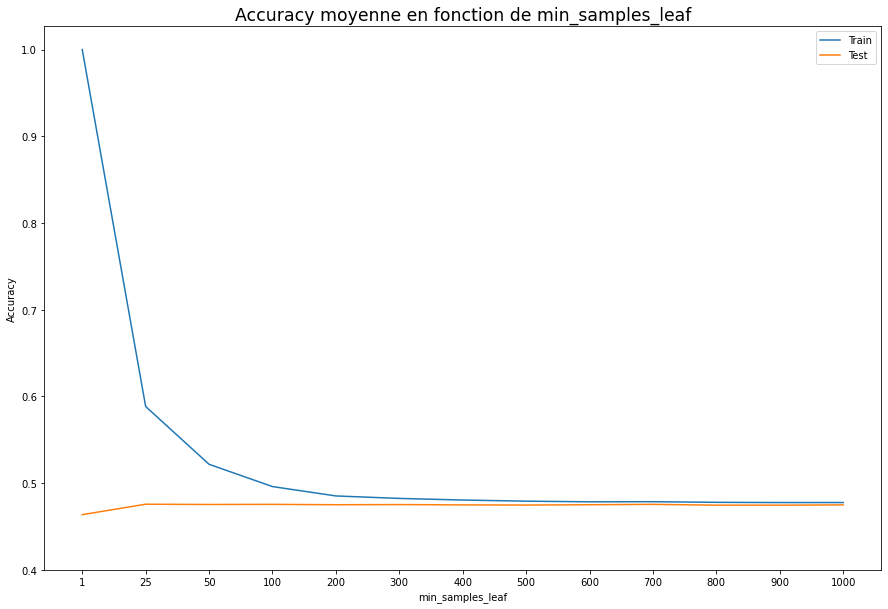

In [14]:
plt.figure(figsize = (15 , 10))
plt.plot(grid_model_rf.cv_results_["mean_train_accuracy"] , label = "Train")
plt.plot(grid_model_rf.cv_results_["mean_test_accuracy"] , label = "Test")
plt.xticks(range(0 , 13) , [1 , 25 , 50 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000])
plt.yticks(np.arange(0.4 , 1.1 , 0.1))
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy moyenne en fonction de min_samples_leaf" , fontsize = "xx-large");

Nous observons que l'overfitting diminue lorsque **min_samples_leaf** augmente.

Tracé du gain en fonction des valeurs de **min_samples_leaf**. Cela permet d'observer pour quelles valeurs du paramètre nous obtenons les meilleurs résultats.

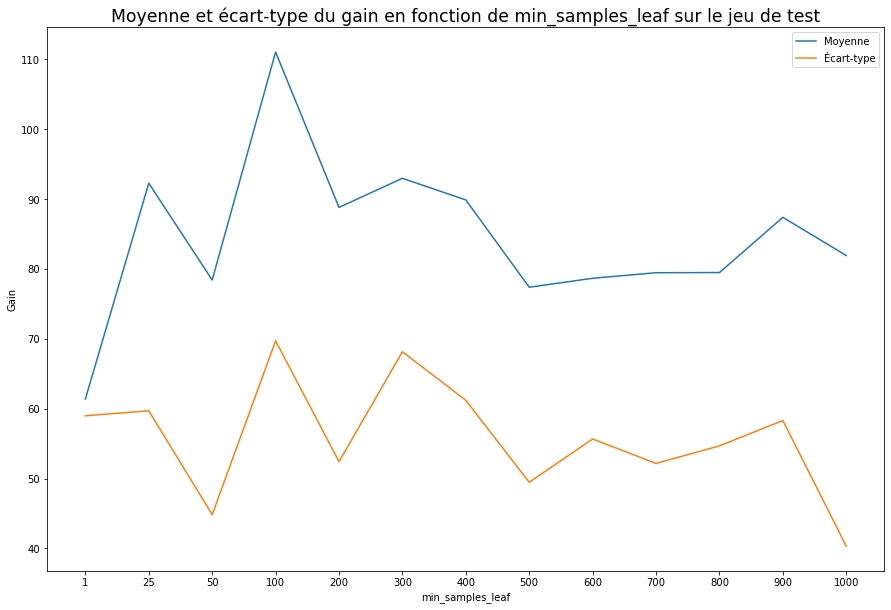

In [15]:
plt.figure(figsize = (15 , 10))
plt.plot(grid_model_rf.cv_results_["mean_test_gain"] , label = "Moyenne")
plt.plot(grid_model_rf.cv_results_["std_test_gain"] , label = "Écart-type")
plt.xticks(range(0 , 13) , [1 , 25 , 50 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000])
plt.xlabel("min_samples_leaf")
plt.ylabel("Gain")
plt.legend()
plt.title("Moyenne et écart-type du gain en fonction de min_samples_leaf sur le jeu de test" , fontsize = "xx-large");

Afin d'éviter l'overfitting et d'augmenter les gains, nous ne conserverons que des valeurs de **min_samples_leaf** comprises entre 50 et 300.

Optimisation du paramètre **max_depth**. Il correspond au nombre de branches maximales par arbre permettant d'arriver à une feuille, un trop grand nombre peut provoquer un surapprentissage.

In [16]:
rf= RandomForestClassifier()

cv = StratifiedKFold(n_splits = 5)
gains_score = make_scorer(score_func = gains , needs_proba = True)
accuracy = make_scorer(score_func = accuracy_score)

params = {"max_depth" : [i for i in range(1 , 21)]}

grid_rf = GridSearchCV(estimator = rf, param_grid= params, scoring = {"gain" : gains_score , "accuracy" : accuracy}, cv= cv, n_jobs= -1, verbose = 2 , return_train_score = True , refit = "gain")

In [17]:
%%time

grid_model_rf = grid_rf.fit(X_train_scaled , y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Wall time: 9min 26s


Tracé de l'accuracy en fonction des valeurs de **max_depth**. Cela nous permet d'observer pour quelles valeurs du paramètre nous pourrions éviter l'overfitting.

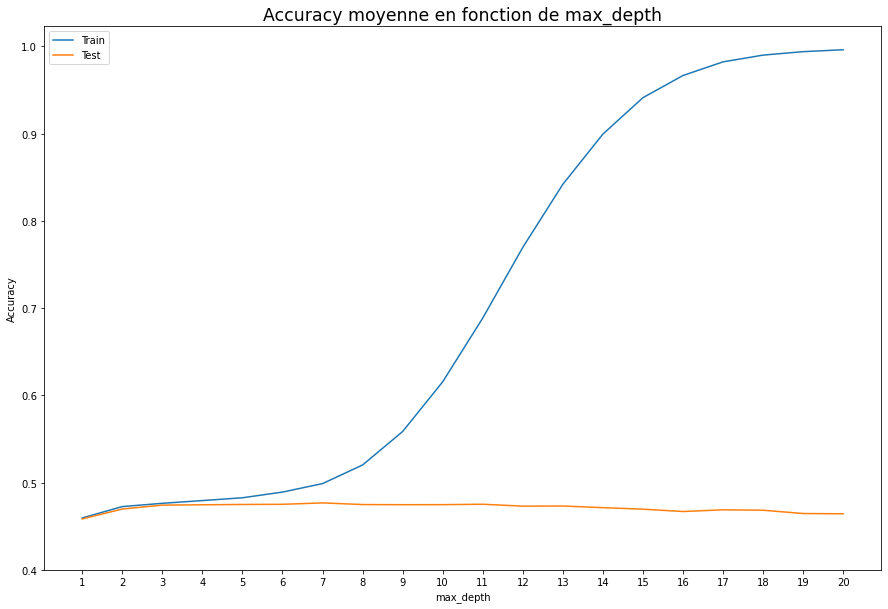

In [18]:
plt.figure(figsize = (15 , 10))
plt.plot(grid_model_rf.cv_results_["mean_train_accuracy"] , label = "Train")
plt.plot(grid_model_rf.cv_results_["mean_test_accuracy"] , label = "Test")
plt.xticks(range(0 , 20) , range(1 , 21))
plt.yticks(np.arange(0.4 , 1.1 , 0.1))
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy moyenne en fonction de max_depth" , fontsize = "xx-large");

Nous observons que l'overfitting augmente lorsque **max_depth** augmente.

Tracé du gain en fonction des valeurs de **max_depth**. Cela permet d'observer pour quelles valeurs du paramètre nous obtenons les meilleurs résultats.

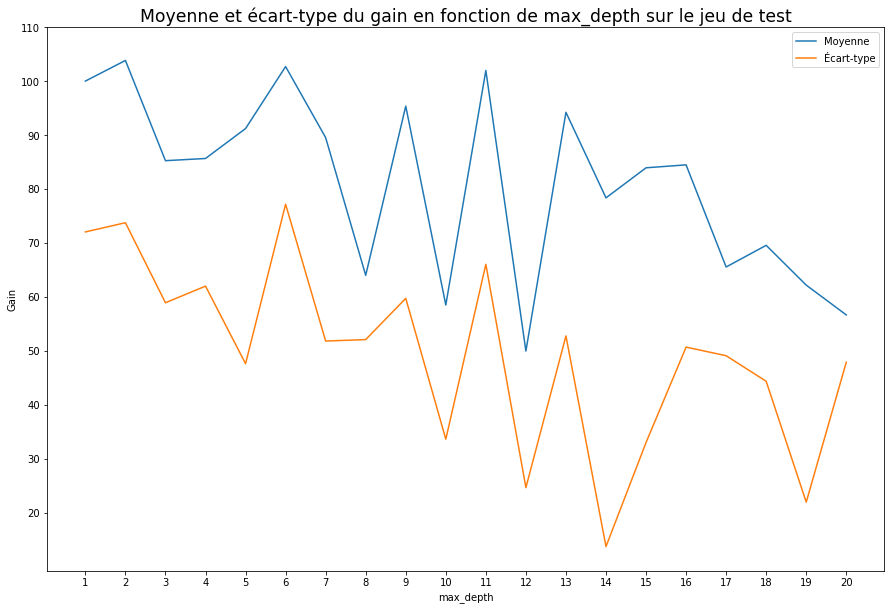

In [19]:
plt.figure(figsize = (15 , 10))
plt.plot(grid_model_rf.cv_results_["mean_test_gain"] , label = "Moyenne")
plt.plot(grid_model_rf.cv_results_["std_test_gain"] , label = "Écart-type")
plt.xticks(range(0 , 20) , range(1 , 21))
plt.yticks(np.arange(20 , 111 , 10))
plt.xlabel("max_depth")
plt.ylabel("Gain")
plt.legend()
plt.title("Moyenne et écart-type du gain en fonction de max_depth sur le jeu de test" , fontsize = "xx-large");

Afin d'éviter l'overfitting et d'augmenter les gains, nous ne conserverons que des valeurs de **max_depth** comprises entre 1 et 7.

Optimisation du paramètre **n_estimators**, qui correspond au nombre d'arbres.

In [20]:
rf= RandomForestClassifier()

cv = StratifiedKFold(n_splits = 5)
gains_score = make_scorer(score_func = gains , needs_proba = True)
accuracy = make_scorer(score_func = accuracy_score)

params = {"n_estimators": [1 , 10 , 25 , 50 , 100 , 250 , 500 , 1000]}

grid_rf = GridSearchCV(estimator = rf, param_grid= params, scoring = {"gain" : gains_score , "accuracy" : accuracy}, cv= cv, n_jobs= -1, verbose = 2 , return_train_score = True , refit = "gain")

In [21]:
%%time

grid_model_rf = grid_rf.fit(X_train_scaled , y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Wall time: 7min 2s


Tracé de l'accuracy en fonction des valeurs de **n_estimators**. Cela nous permet d'observer pour quelles valeurs du paramètre nous pourrions éviter l'overfitting.

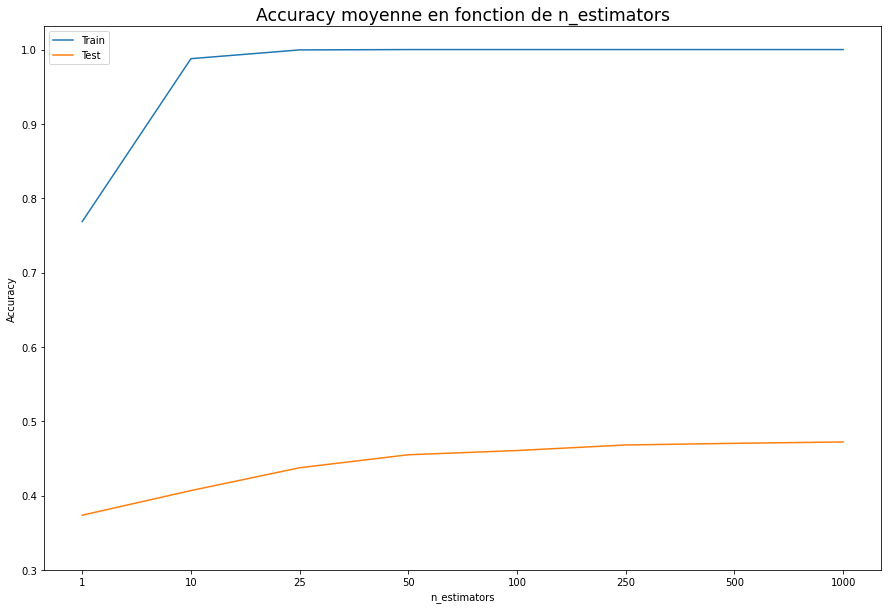

In [22]:
plt.figure(figsize = (15 , 10))
plt.plot(grid_model_rf.cv_results_["mean_train_accuracy"] , label = "Train")
plt.plot(grid_model_rf.cv_results_["mean_test_accuracy"] , label = "Test")
plt.xticks(range(0 , 8) , [1 , 10 , 25 , 50 , 100 , 250 , 500 , 1000])
plt.yticks(np.arange(0.3 , 1.1 , 0.1))
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy moyenne en fonction de n_estimators" , fontsize = "xx-large");

Nous observons que nous avons systématiquement de l'overfitting quelle que soit la valeur de **n_estimators**.

Tracé du gain en fonction des valeurs de **n_estimators**. Cela permet d'observer pour quelles valeurs du paramètre nous obtenons les meilleurs résultats.

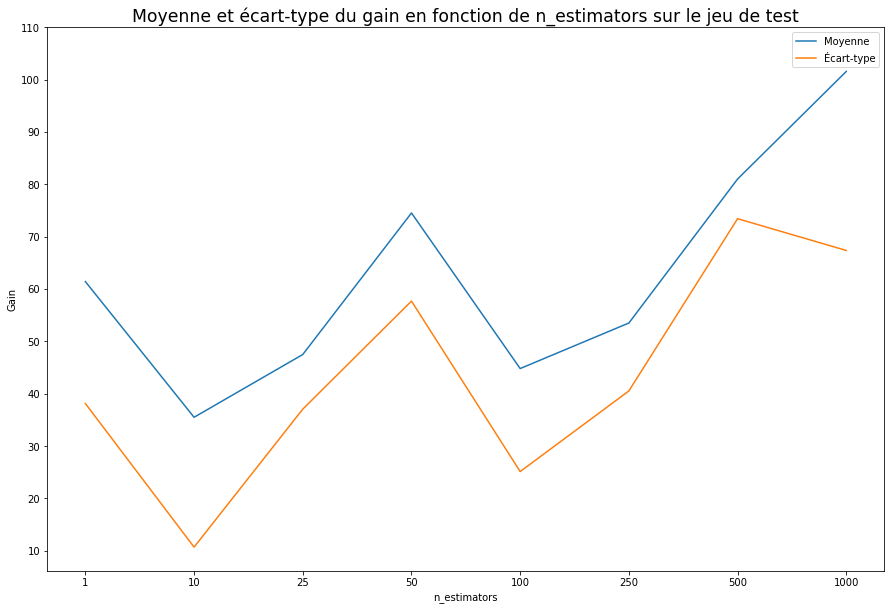

In [23]:
plt.figure(figsize = (15 , 10))
plt.plot(grid_model_rf.cv_results_["mean_test_gain"] , label = "Moyenne")
plt.plot(grid_model_rf.cv_results_["std_test_gain"] , label = "Écart-type")
plt.xticks(range(0 , 8) , [1 , 10 , 25 , 50 , 100 , 250 , 500 , 1000])
plt.yticks(np.arange(10 , 111 , 10))
plt.xlabel("n_estimators")
plt.ylabel("Gain")
plt.legend()
plt.title("Moyenne et écart-type du gain en fonction de n_estimators sur le jeu de test" , fontsize = "xx-large");

Il est difficile de tirer des conclusions sur **n_estimators**, nous avons décidé de tester des valeurs entre 100 et 500.

Maintenant que nous avons determiné une plage optimisée pour tous nos paramètres, nous pouvons refaire une GridSearchCV sur cette base.

In [24]:
rf= RandomForestClassifier()

cv = StratifiedKFold(n_splits = 3)
gains_score = make_scorer(score_func = gains , needs_proba = True)
accuracy = make_scorer(score_func = accuracy_score)

params = {
    "n_estimators": [100 , 200 , 300 , 400 , 500],
    "min_samples_leaf": [50 , 100 , 150 , 200 , 250 , 300],
    "max_depth" : [i for i in range(1 , 8)]
         }

grid_rf = GridSearchCV(estimator = rf, param_grid= params, scoring = {"gain" : gains_score , "accuracy" : accuracy}, cv= cv, n_jobs= -1, verbose = 2 , return_train_score = True , refit = "gain")

In [25]:
%%time

grid_model_rf = grid_rf.fit(X_train_scaled , y_train)

Fitting 3 folds for each of 210 candidates, totalling 630 fits
Wall time: 58min 10s


Tracé de l'accuracy en fonction des combinaisons d'hyperparamètres. Cela nous permet d'observer pour quelles valeurs des paramètres nous pourrions éviter l'overfitting.

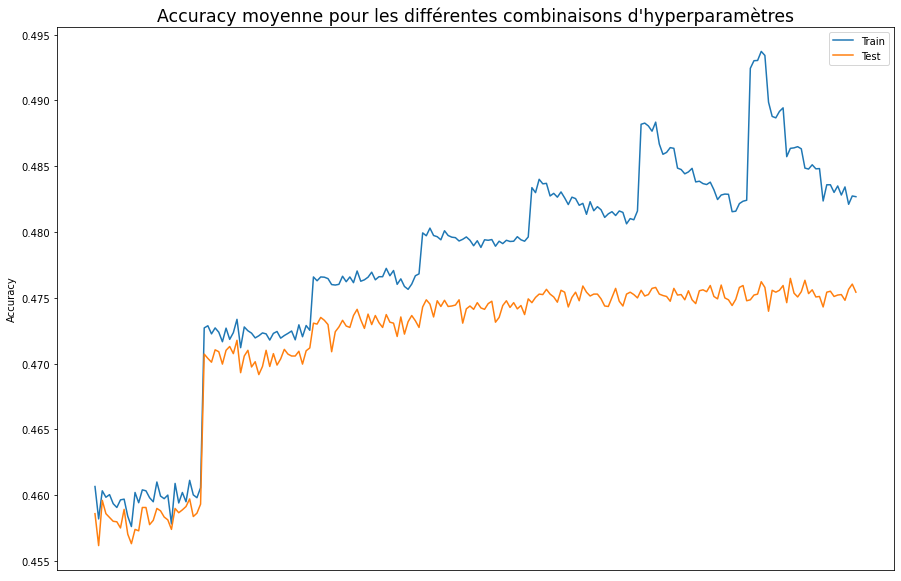

In [26]:
plt.figure(figsize = (15 , 10))
plt.plot(grid_model_rf.cv_results_["mean_train_accuracy"] , label = "Train")
plt.plot(grid_model_rf.cv_results_["mean_test_accuracy"] , label = "Test")
plt.xticks([])
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy moyenne pour les différentes combinaisons d'hyperparamètres" , fontsize = "xx-large");

Grâce à nos sélections sur les paramètres, nous n'avons pas d'overfitting sur les combinaisons que nous testons.

Tracé du gain en fonction des combinaisons d'hyperparamètres. Cela permet d'observer pour quelles valeurs des paramètres nous obtenons les meilleurs résultats.

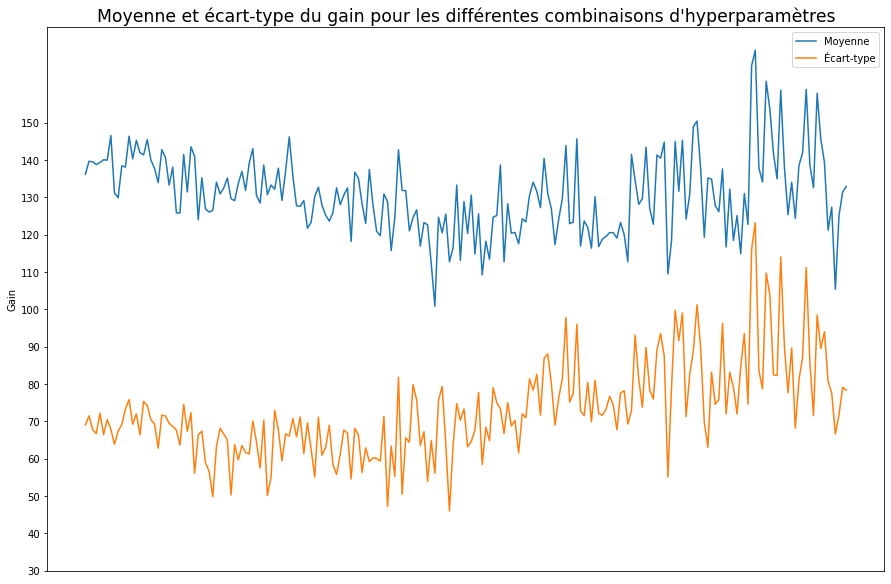

In [27]:
plt.figure(figsize = (15 , 10))
plt.plot(grid_model_rf.cv_results_["mean_test_gain"] , label = "Moyenne")
plt.plot(grid_model_rf.cv_results_["std_test_gain"] , label = "Écart-type")
plt.xticks([])
plt.yticks(np.arange(30 , 151 , 10))
plt.ylabel("Gain")
plt.legend()
plt.title("Moyenne et écart-type du gain pour les différentes combinaisons d'hyperparamètres" , fontsize = "xx-large");

Comme nous n'avons pas d'overfitting, nous pouvons simplement choisir le meilleur algorithme que nous retourne la recherche d'hyperparamètres.

Sélection du meilleur modèle.

In [28]:
best_rf = grid_model_rf.best_estimator_
best_rf

RandomForestClassifier(max_depth=7, min_samples_leaf=50, n_estimators=500)

Entrainement du modèle.

In [29]:
best_rf.fit(X_train_scaled , y_train)

RandomForestClassifier(max_depth=7, min_samples_leaf=50, n_estimators=500)

Calcul de l'accuracy sur le jeu de données d'entrainement (pour vérifier l'absence d'overfitting).

In [30]:
y_preds_train_rf = best_rf.predict(X_train_scaled)
y_probs_train_rf = best_rf.predict_proba(X_train_scaled)

print("Accuracy sur le jeu de données d'entrainement :" , round(100 * accuracy_score(y_train , y_preds_train_rf) , 2) , "%")

Accuracy sur le jeu de données d'entrainement : 48.88 %


Calcul de l'accuracy sur le jeu de données de test (pour vérifier l'absence d'overfitting).

In [31]:
y_preds_test_rf = best_rf.predict(X_test_scaled)
y_probs_test_rf = best_rf.predict_proba(X_test_scaled)

print("Accuracy sur le jeu de données de test :" , round(100 * accuracy_score(y_test , y_preds_test_rf) , 2) , "%")

Accuracy sur le jeu de données de test : 47.41 %


Les valeurs sont proches, nous n'avons pas d'overfitting.

Détermination des variables explicatives les plus importantes.

[51/51] features ████████████████████ Time elapsed: 46 seconds

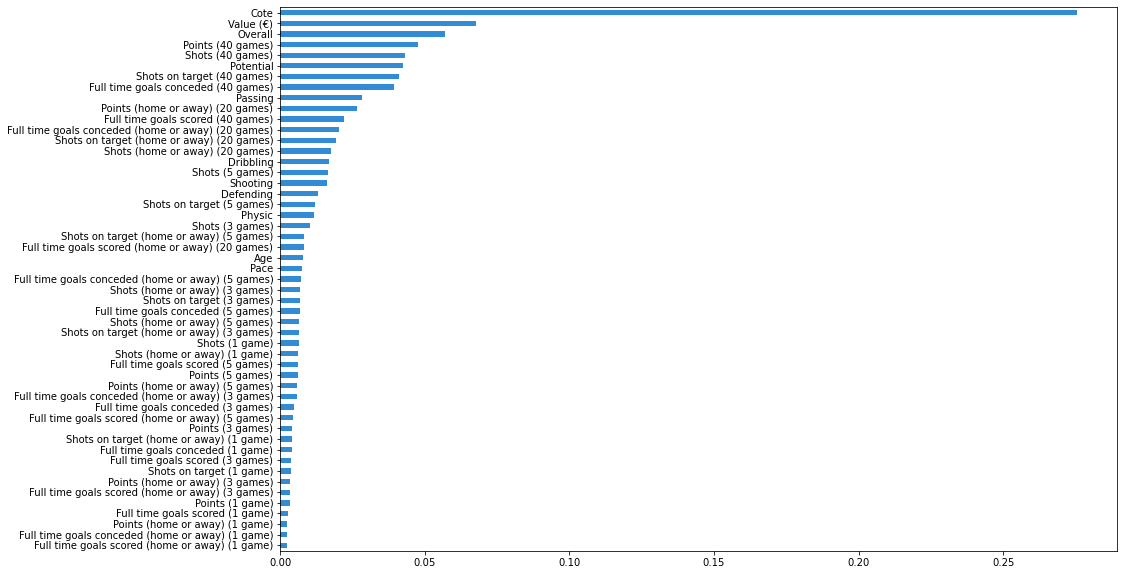

In [32]:
interpreter = Interpretation(X_train_scaled , feature_names = X_train_scaled.columns)

def predict_rf(x):
    return pd.DataFrame(best_rf.predict_proba(x))

model = InMemoryModel(predict_rf , examples = X_train)
fig , ax = plt.subplots(figsize = (15 , 10))
interpreter.feature_importance.plot_feature_importance(model , ax = ax , ascending = False);

Nous pouvons observer que la variable **Cote** est de loin celle qui influence le plus notre modèle.

Regardons désormais le gain maximum obtenu.

In [33]:
infos_gains_max(y_test , y_probs_test_rf)

Gain max : 19.25
Nombre de matchs : 24
ROI : 80.21 %


Le gain maximum correspond au maximum de la courbe rouge ci-dessous. Nous pouvons voir que le gain maximum est atteint très tôt, pour seulement les 24 meilleurs Value Bets. Nous avons donc un ROI très élevé, mais pour un nombre de matchs insuffisant, ce qui n'est pas exploitable pour espérer une stratégie de pari gagnante à long terme.

Tracé des graphes des résultats.

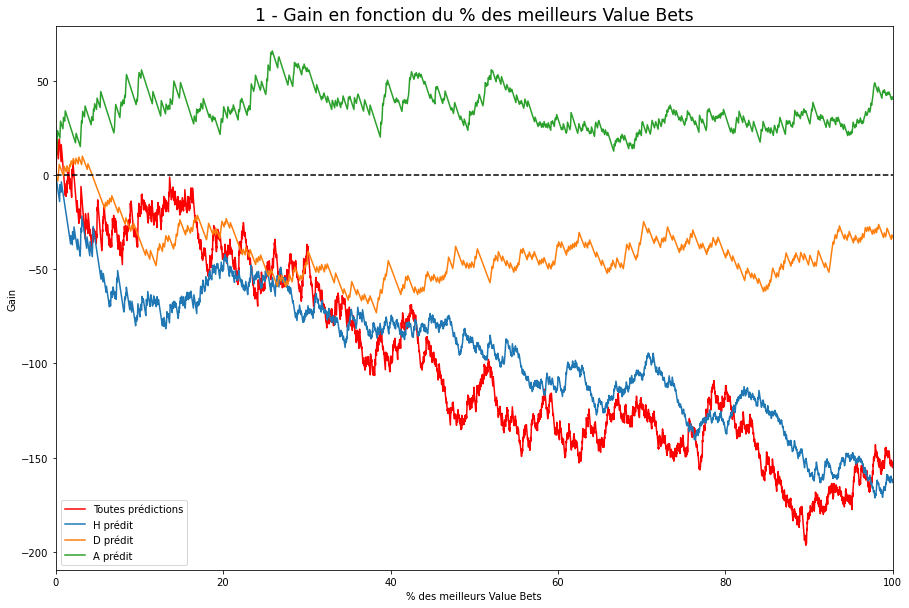

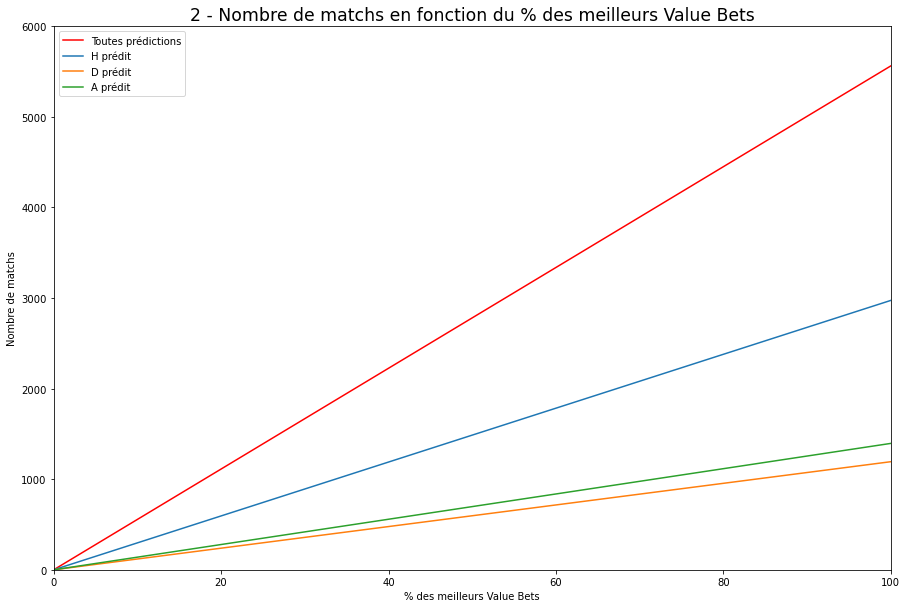

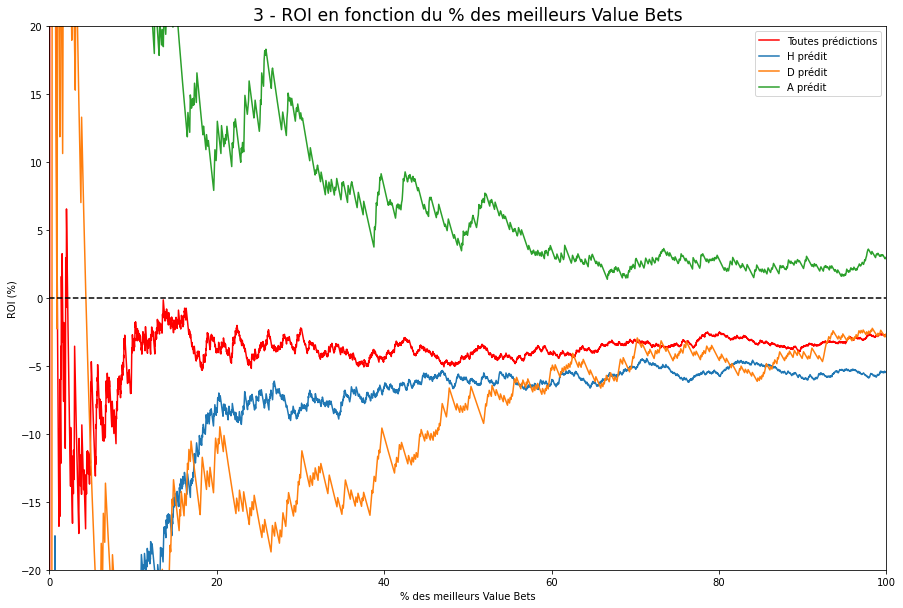

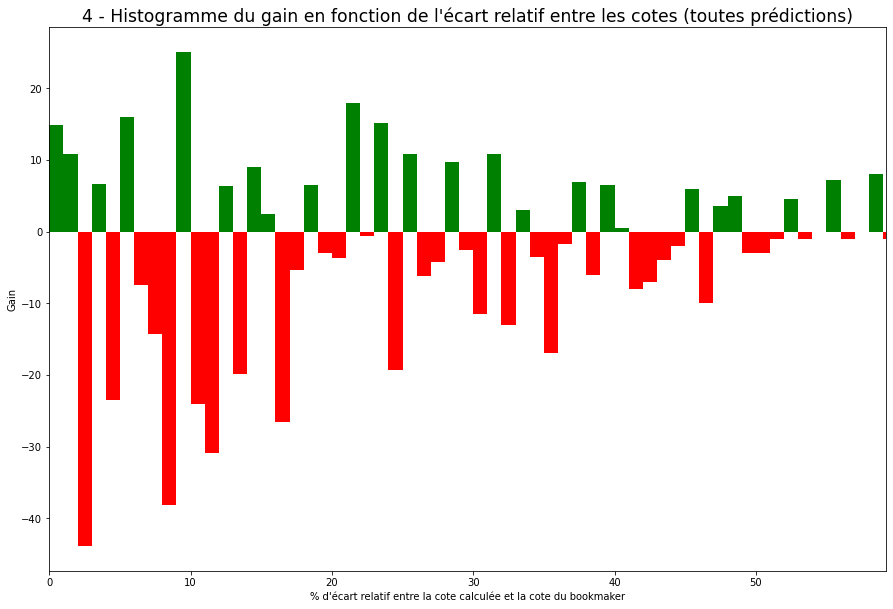

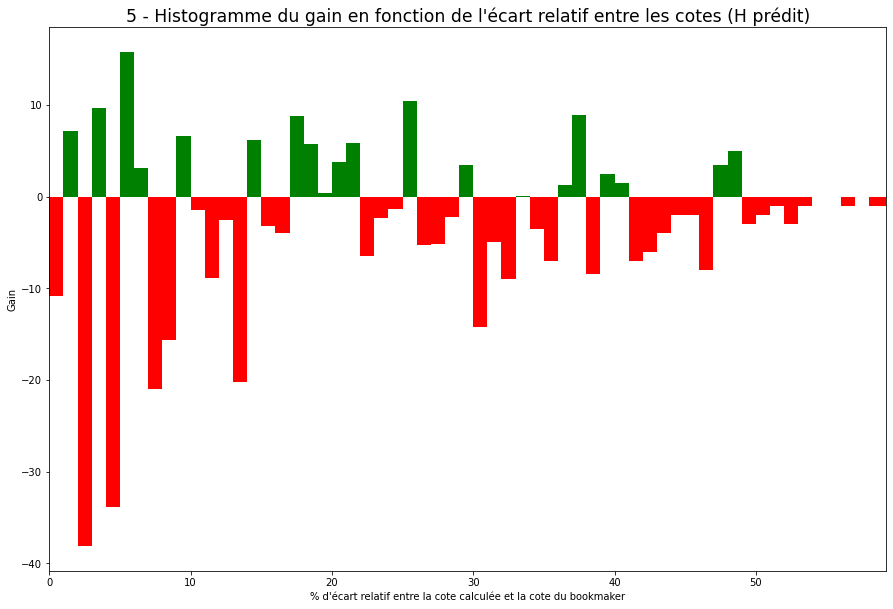

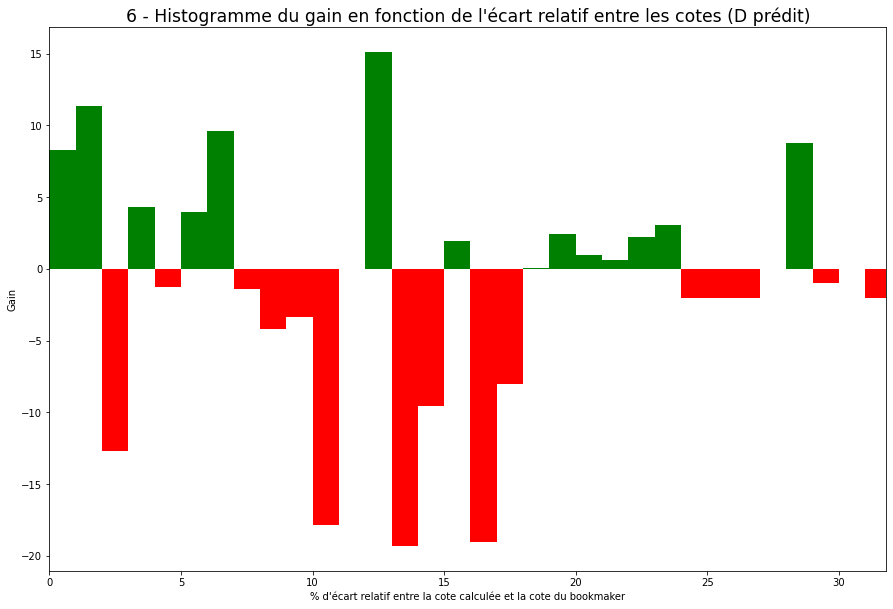

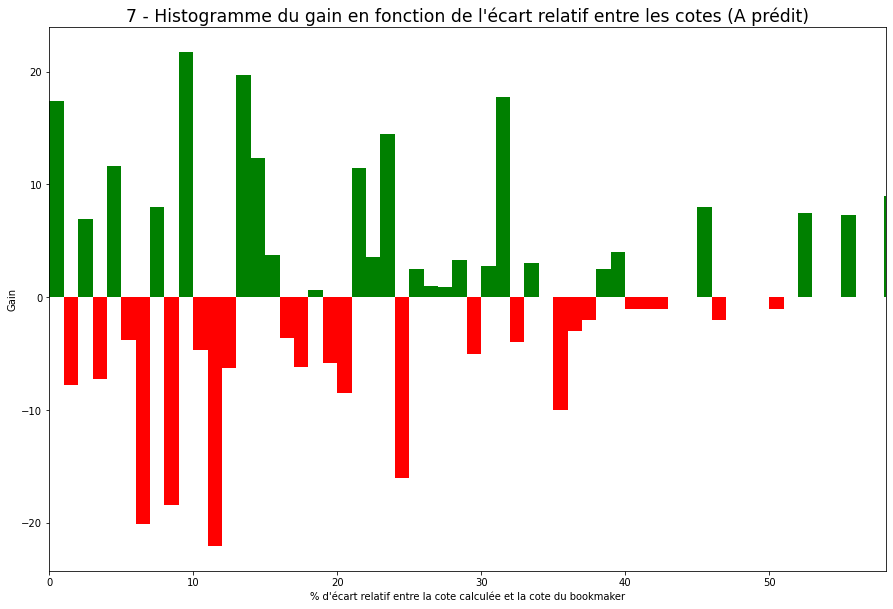

In [34]:
graphes(y_test , y_probs_test_rf)

Nous ne rentrerons pas ici dans le détail des résultats, ce sera fait dans le rapport pour le modèle ayant obtenu les meilleurs résultats.

# 4.2 SVC

Après avoir étudié le Random Forest, notre 2ème algorithme est le SVC, l'idée est de voir comment se comporte un modèle plus simple à mettre en oeuvre sur notre jeu de données.

Dans un 1er temps, nous recherchons les meilleurs hyperparamètres à l'aide de GridSearchCV. Pour le SVC, nous ne testons que le paramètre **C** qui nous permet d'obtenir une marge optimale afin de différencier les différentes classes.

Optimisation du paramètre **C**.

In [35]:
svc = SVC(probability = True)

cv = StratifiedKFold(n_splits = 5)
gains_score = make_scorer(score_func = gains , needs_proba = True)
accuracy = make_scorer(score_func = accuracy_score)

params = {"C" : [0.01 , 0.05 , 0.1 , 0.5 , 1 , 5 , 10]}

grid_svc = GridSearchCV(estimator = svc , param_grid = params , cv = cv , scoring = {"gain" : gains_score , "accuracy" : accuracy} , n_jobs = -1 , return_train_score = True , verbose = 2 , refit = "gain")

In [36]:
%%time

grid_model_svc = grid_svc.fit(X_train_scaled , y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Wall time: 1h 15min 33s


Tracé de l'accuracy en fonction des valeurs de **C**. Cela nous permet d'observer pour quelles valeurs du paramètre nous pourrions éviter l'overfitting.

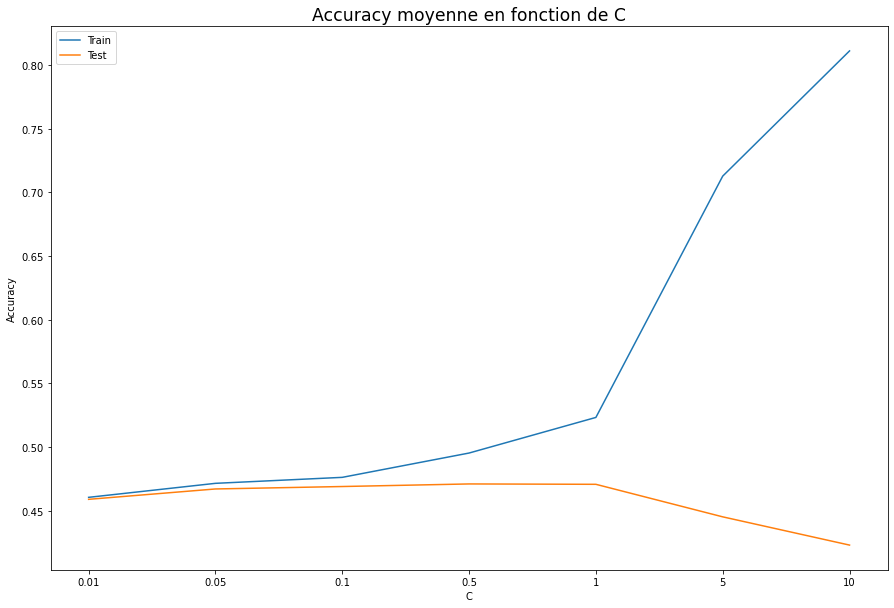

In [37]:
plt.figure(figsize = (15 , 10))
plt.plot(grid_model_svc.cv_results_["mean_train_accuracy"] , label = "Train")
plt.plot(grid_model_svc.cv_results_["mean_test_accuracy"] , label = "Test")
plt.xticks(range(0 , 7) , [0.01 , 0.05 , 0.1 , 0.5 , 1 , 5 , 10])
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy moyenne en fonction de C" , fontsize = "xx-large");

Nous pouvons voir que l'overfitting augmente lorsque **C** augmente.

Tracé du gain en fonction des valeurs de **C**. Cela permet d'observer pour quelles valeurs du paramètre nous obtenons les meilleurs résultats.

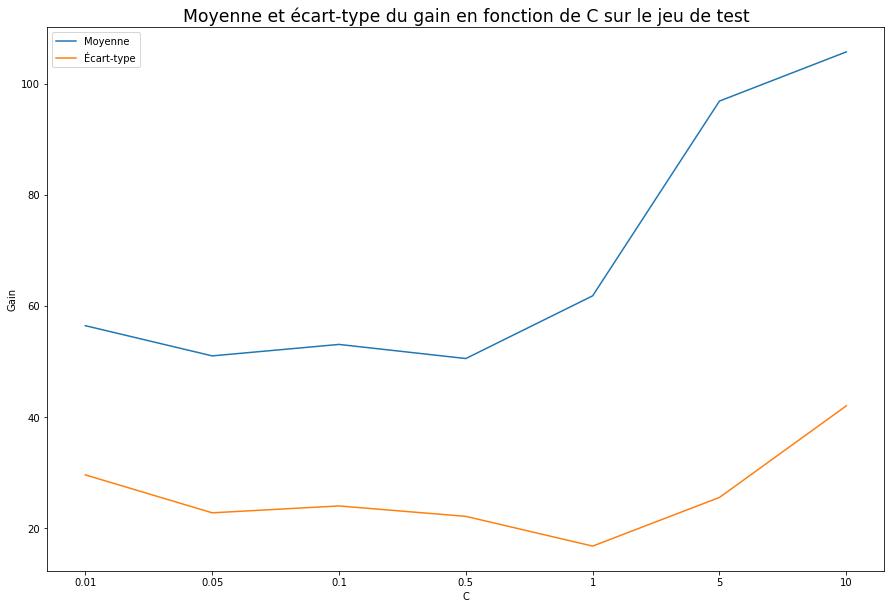

In [38]:
plt.figure(figsize = (15 , 10))
plt.plot(grid_model_svc.cv_results_["mean_test_gain"] , label = "Moyenne")
plt.plot(grid_model_svc.cv_results_["std_test_gain"] , label = "Écart-type")
plt.xticks(range(0 , 7) , [0.01 , 0.05 , 0.1 , 0.5 , 1 , 5 , 10])
plt.xlabel("C")
plt.ylabel("Gain")
plt.legend()
plt.title("Moyenne et écart-type du gain en fonction de C sur le jeu de test" , fontsize = "xx-large");

Afin d'éviter l'overfitting et d'augmenter les gains, nous ne conserverons que des valeurs de **C** comprises entre 0,01 et 0,5.

Maintenant que nous avons determiné une plage optimisée pour notre paramètre **C**, nous pouvons refaire une GridSearchCV sur avec une sélection affinée. Nous ajoutons aussi l'optimisation du paramètre **kernel**.

In [39]:
svc = SVC(probability = True)

cv = StratifiedKFold(n_splits = 5)
gains_score = make_scorer(score_func = gains , needs_proba = True)
accuracy = make_scorer(score_func = accuracy_score)

params = {"kernel" : ["sigmoid" , "rbf"] ,
          "C" : [0.01 , 0.05 , 0.1 , 0.2 , 0.3 , 0.4 , 0.5]}

grid_svc = GridSearchCV(estimator = svc , param_grid = params , cv = cv , scoring = {"gain" : gains_score , "accuracy" : accuracy} , n_jobs = -1 , return_train_score = True , verbose = 2 , refit = "gain")

In [40]:
%%time

grid_model_svc = grid_svc.fit(X_train_scaled , y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Wall time: 1h 41min 36s


Tracé de l'accuracy en fonction des valeurs des hyperparamètres. Cela nous permet d'observer pour quelles valeurs des paramètres nous pourrions éviter l'overfitting.

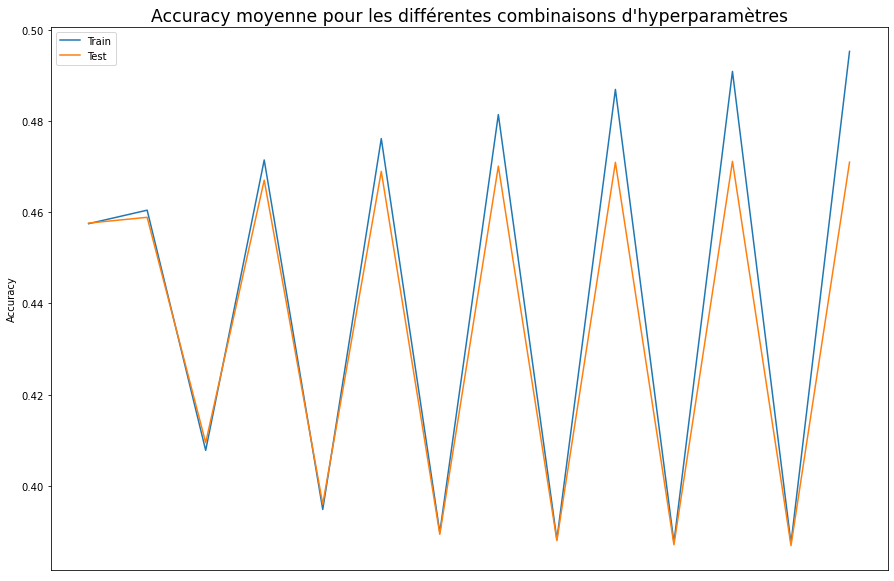

In [41]:
plt.figure(figsize = (15 , 10))
plt.plot(grid_model_svc.cv_results_["mean_train_accuracy"] , label = "Train")
plt.plot(grid_model_svc.cv_results_["mean_test_accuracy"] , label = "Test")
plt.xticks([])
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy moyenne pour les différentes combinaisons d'hyperparamètres" , fontsize = "xx-large");

Grâce à notre nouvelle sélection nous n'avons plus d'overfitting.

Tracé du gain en fonction des combinaisons d'hyperparamètres. Cela permet d'observer pour quelles valeurs des paramètres nous obtenons les meilleurs résultats.

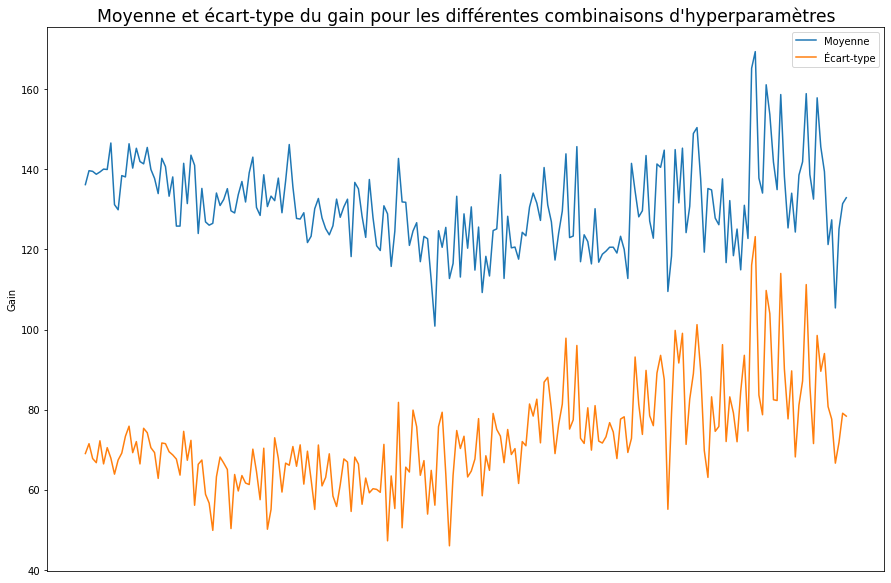

In [42]:
plt.figure(figsize = (15 , 10))
plt.plot(grid_model_rf.cv_results_["mean_test_gain"] , label = "Moyenne")
plt.plot(grid_model_rf.cv_results_["std_test_gain"] , label = "Écart-type")
plt.xticks([])
plt.ylabel("Gain")
plt.legend()
plt.title("Moyenne et écart-type du gain pour les différentes combinaisons d'hyperparamètres" , fontsize = "xx-large");

Comme nous n'avons pas d'overfitting, nous pouvons simplement choisir le meilleur algorithme que nous retourne la recherche d'hyperparamètres.

Sélection du meilleur modèle.

In [43]:
best_svc = grid_model_svc.best_estimator_
best_svc

SVC(C=0.4, kernel='sigmoid', probability=True)

Entrainement du modèle.

In [44]:
best_svc.fit(X_train_scaled , y_train)

SVC(C=0.4, kernel='sigmoid', probability=True)

Calcul de l'accuracy sur le jeu de données d'entrainement (pour vérifier l'absence d'overfitting).

In [45]:
y_preds_train_svc = best_svc.predict(X_train_scaled)
y_probs_train_svc = best_svc.predict_proba(X_train_scaled)

print("Accuracy :" , round(100 * accuracy_score(y_train , y_preds_train_svc) , 2) , "%")

Accuracy : 39.71 %


Calcul de l'accuracy sur le jeu de données de test (pour vérifier l'absence d'overfitting).

In [46]:
y_preds_test_svc = best_svc.predict(X_test_scaled)
y_probs_test_svc = best_svc.predict_proba(X_test_scaled)

print("Accuracy :" , round(100 * accuracy_score(y_test , y_preds_test_svc) , 2) , "%")

Accuracy : 38.91 %


Les valeurs sont proches, nous n'avons pas d'overfitting.

Détermination des variables explicatives les plus importantes.

[51/51] features ████████████████████ Time elapsed: 863 seconds

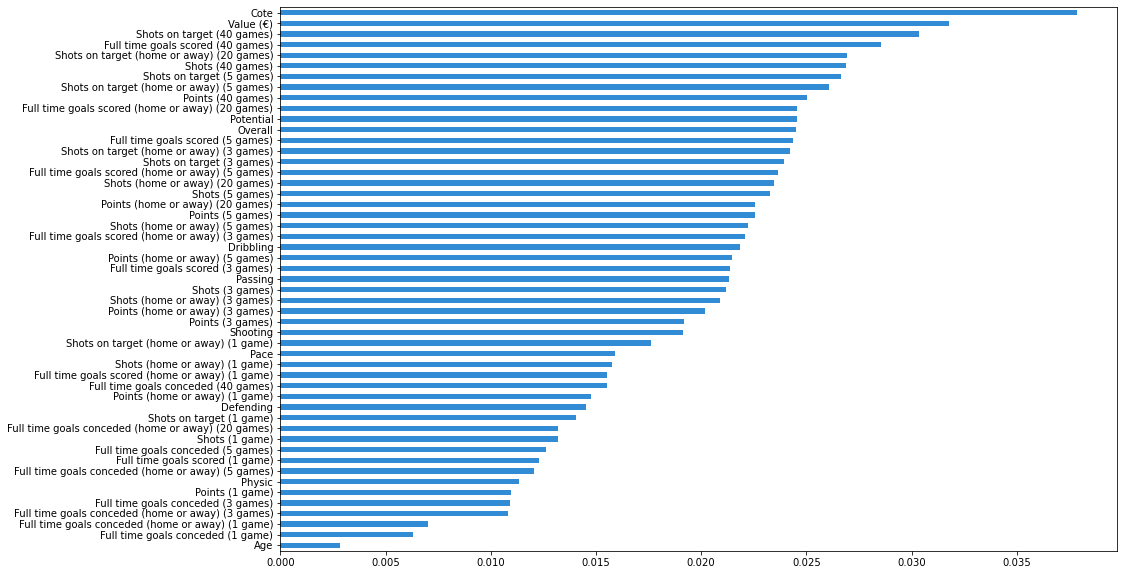

In [47]:
interpreter = Interpretation(X_train_scaled , feature_names = X_train_scaled.columns)

def predict_svc(x):
    return pd.DataFrame(best_svc.predict_proba(x))

model = InMemoryModel(predict_svc , examples = X_train)
fig , ax = plt.subplots(figsize = (15 , 10))
interpreter.feature_importance.plot_feature_importance(model , ax = ax , ascending = False);

Nous pouvons observer que la variable **Cote** est celle qui influence le plus notre modèle. Il n'y a cependant pas beaucoup d'écart entre les différentes variables explicatives.

Regardons désormais le gain maximum obtenu.

In [48]:
infos_gains_max(y_test , y_probs_test_svc)

Gain max : 1.0
Nombre de matchs : 9
ROI : 11.11 %


Le gain maximum correspond au maximum de la courbe rouge ci-dessous. Nous pouvons voir que le gain maximum est atteint très tôt, pour le 1er Value Bet. Nous avons donc un ROI très élevé, mais pour un nombre de matchs insuffisant, ce qui n'est pas exploitable pour espérer une stratégie de pari gagnante à long terme.

Tracé des graphes des résultats.

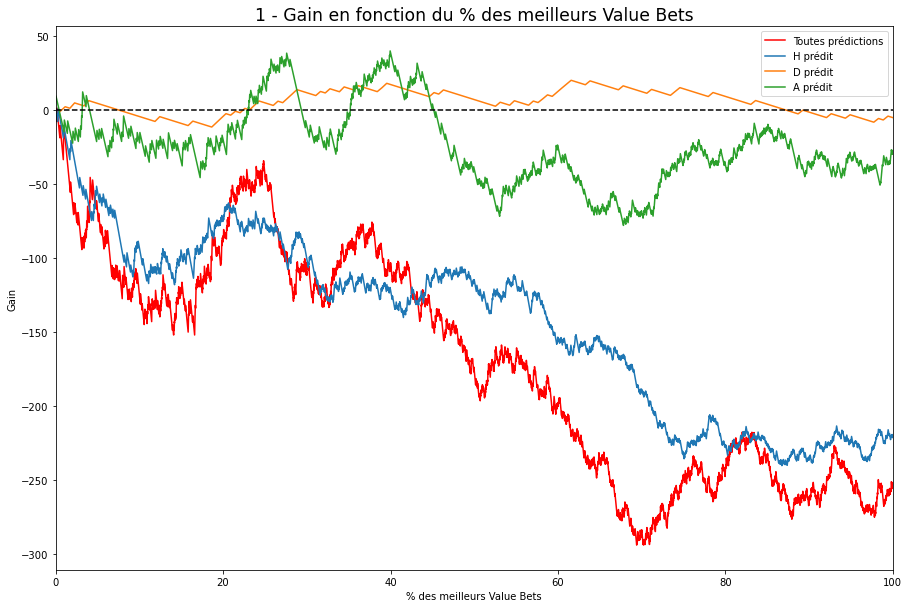

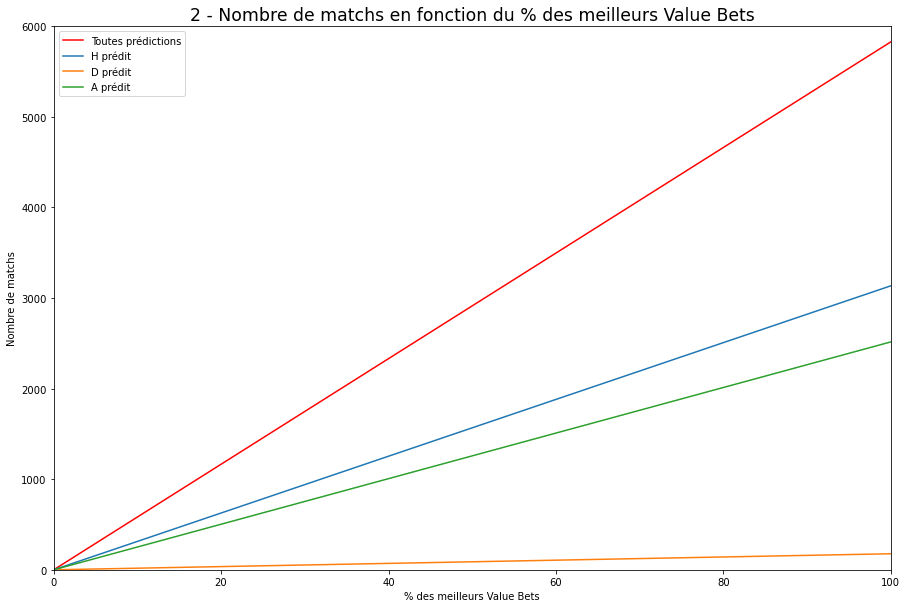

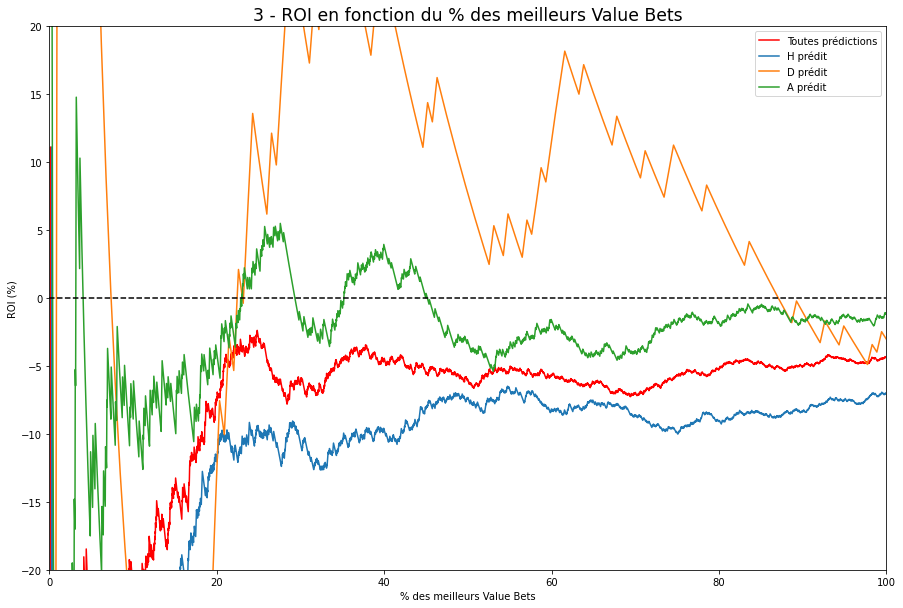

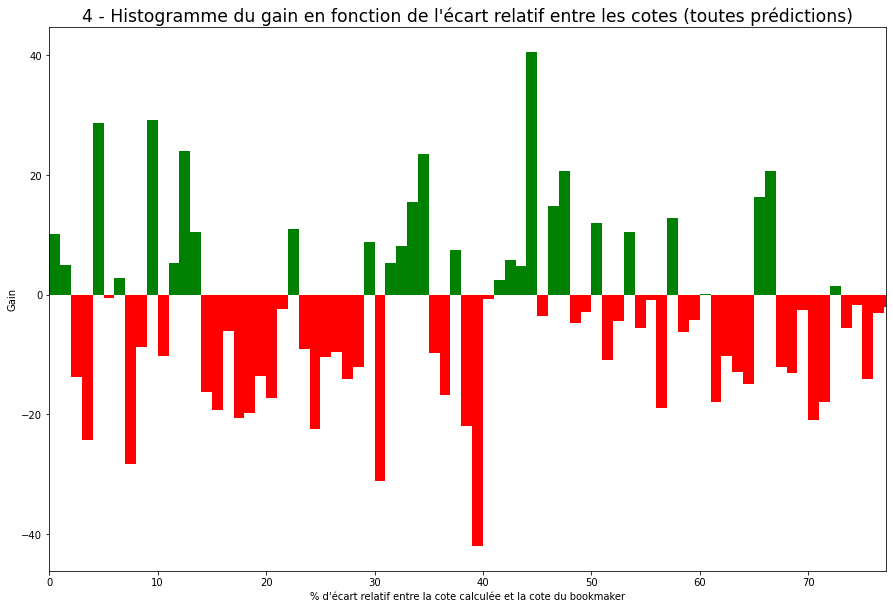

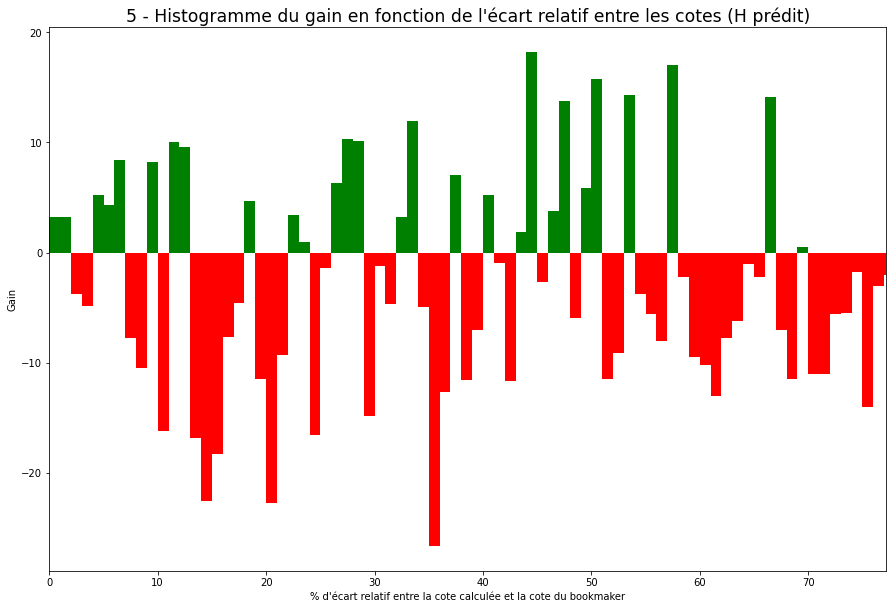

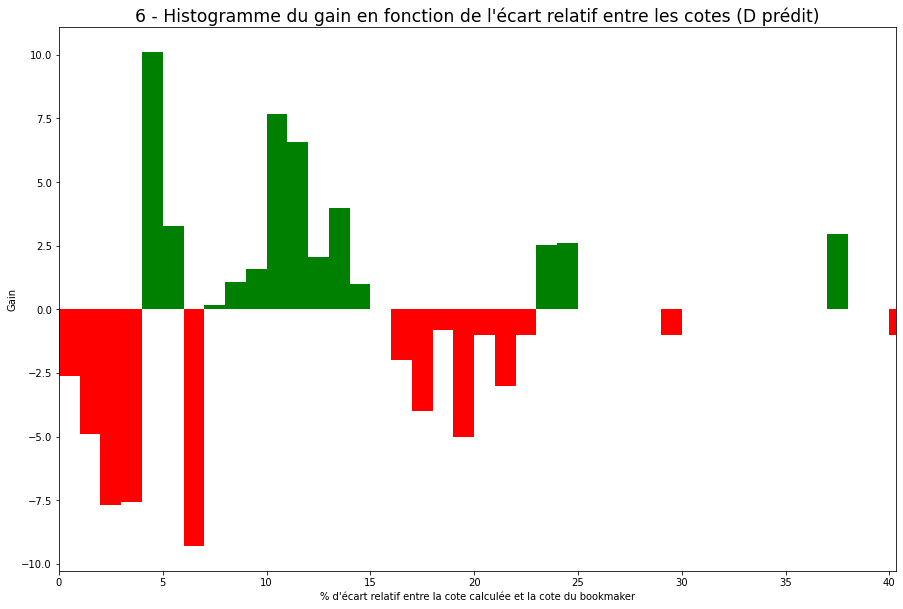

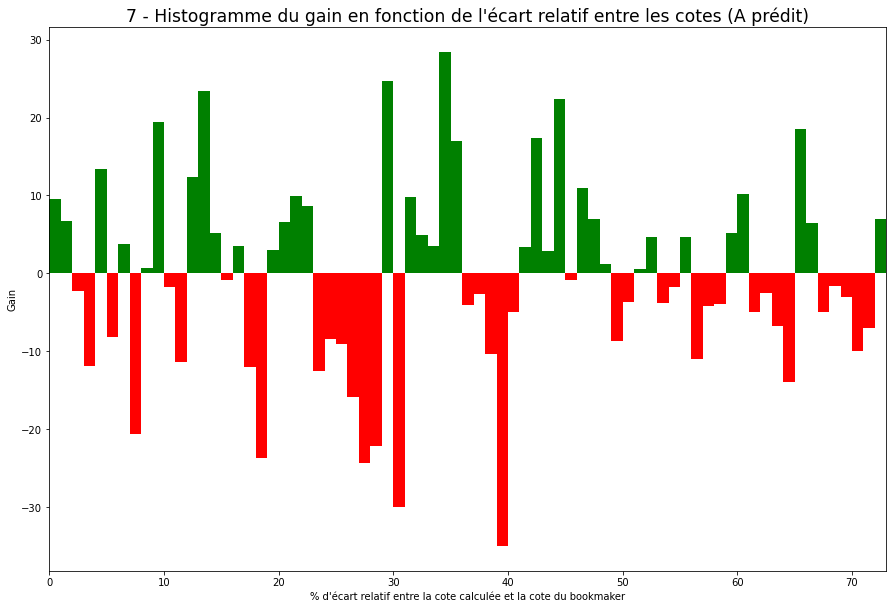

In [49]:
graphes(y_test , y_probs_test_svc)

Nous ne rentrerons pas ici dans le détail des résultats, ce sera fait dans le rapport pour le modèle ayant obtenu les meilleurs résultats.

# 4.3 KNN

Notre 3ème algorithme est le KNN.

Pour le KNN, nous ne testerons que le paramètre **n_neighbors**, qui correspond au nombre de voisins utilisés pour la décision.

Optimisation du paramètre **n_neighbors**.

In [50]:
knn = KNeighborsClassifier()

cv = StratifiedKFold(n_splits = 5)
gains_score = make_scorer(score_func = gains , needs_proba = True)
accuracy = make_scorer(score_func = accuracy_score)

params = {"n_neighbors" : [i for i in range(50 , 201)]}

grid_knn = GridSearchCV(estimator = knn , param_grid = params , cv = cv , scoring = {"gain" : gains_score , "accuracy" : accuracy} , n_jobs = -1 , verbose = 2 , return_train_score = True , refit = "gain")

In [51]:
%%time

grid_model_knn = grid_knn.fit(X_train_scaled , y_train)

Fitting 5 folds for each of 151 candidates, totalling 755 fits
Wall time: 3h 16min 34s


Tracé de l'accuracy en fonction des valeurs de **n_neighbors**. Cela nous permet d'observer pour quelles valeurs du paramètre nous pourrions éviter l'overfitting.

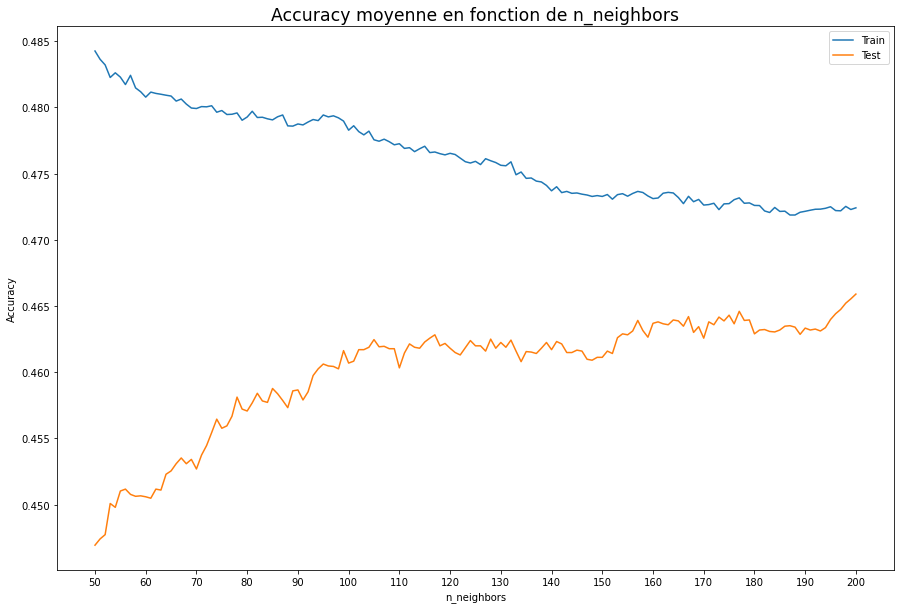

In [72]:
plt.figure(figsize = (15 , 10))
plt.plot(grid_model_knn.cv_results_["mean_train_accuracy"] , label = "Train")
plt.plot(grid_model_knn.cv_results_["mean_test_accuracy"] , label = "Test")
plt.xticks(range(0 , 151 , 10) , [i for i in range(50 , 201 , 10)])
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy moyenne en fonction de n_neighbors" , fontsize = "xx-large");

Nous observons que plus **n_neighbors** augmente moins nous avons d'ovefitting. Cependant, nous n'avons pas d'overfitting sur la plage de données sélectionnée.

Tracé du gain en fonction des valeurs de **n_neighbors**. Cela permet d'observer pour quelles valeurs du paramètre nous obtenons les meilleurs résultats.

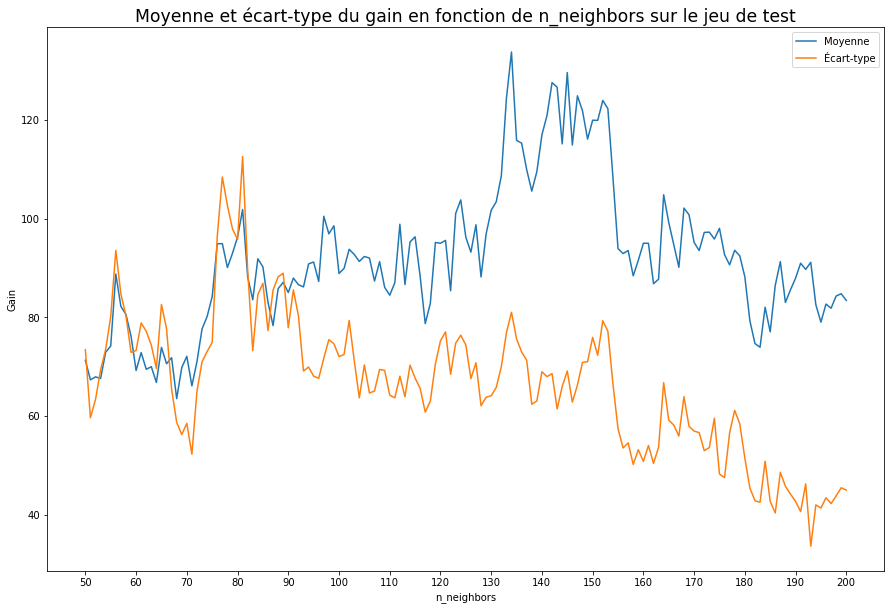

In [53]:
plt.figure(figsize = (15 , 10))
plt.plot(grid_model_knn.cv_results_["mean_test_gain"] , label = "Moyenne")
plt.plot(grid_model_knn.cv_results_["std_test_gain"] , label = "Écart-type")
plt.xticks(range(0 , 151 , 10) , [i for i in range(50 , 201 , 10)])
plt.xlabel("n_neighbors")
plt.ylabel("Gain")
plt.legend()
plt.title("Moyenne et écart-type du gain en fonction de n_neighbors sur le jeu de test" , fontsize = "xx-large");

Comme nous n'avons pas d'overfitting, nous pouvons simplement choisir le meilleur algorithme que nous retourne la recherche d'hyperparamètres.

Sélection du meilleur modèle.

In [54]:
best_knn = grid_model_knn.best_estimator_
best_knn

KNeighborsClassifier(n_neighbors=134)

Entrainement du modèle.

In [55]:
best_knn.fit(X_train_scaled , y_train)

KNeighborsClassifier(n_neighbors=134)

Calcul de l'accuracy sur le jeu de données d'entrainement (pour vérifier l'absence d'overfitting).

In [56]:
y_preds_train_knn = best_knn.predict(X_train_scaled)
y_probs_train_knn = best_knn.predict_proba(X_train_scaled)

print("Accuracy :" , round(100 * accuracy_score(y_train , y_preds_train_knn) , 2) , "%")

Accuracy : 47.8 %


Calcul de l'accuracy sur le jeu de données de test (pour vérifier l'absence d'overfitting).

In [57]:
y_preds_test_knn = best_knn.predict(X_test_scaled)
y_probs_test_knn = best_knn.predict_proba(X_test_scaled)

print("Accuracy :" , round(100 * accuracy_score(y_test , y_preds_test_knn) , 2) , "%")

Accuracy : 46.07 %


Les valeurs sont proches, nous n'avons pas d'overfitting.

Détermination des variables explicatives les plus importantes.

[51/51] features ████████████████████ Time elapsed: 552 seconds

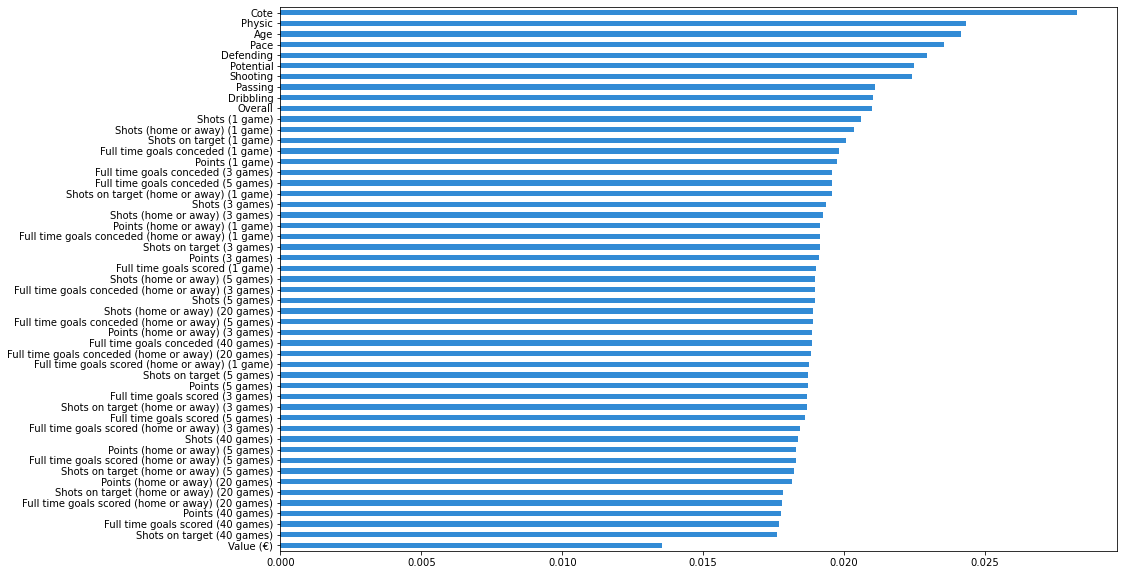

In [58]:
interpreter = Interpretation(X_train_scaled , feature_names = X_train_scaled.columns)

def predict_knn(x):
    return pd.DataFrame(best_knn.predict_proba(x))

model = InMemoryModel(predict_knn , examples = X_train)
fig , ax = plt.subplots(figsize = (15 , 10))
interpreter.feature_importance.plot_feature_importance(model , ax = ax , ascending = False);

Nous pouvons observer que la variable **Cote** est celle qui influence le plus notre modèle. Il n'y a cependant pas beaucoup d'écart entre les différentes variables explicatives.

Regardons désormais le gain maximum obtenu.

In [62]:
infos_gains_max(y_test , y_probs_test_knn)

Gain max : 56.72
Nombre de matchs : 1746
ROI : 3.25 %


Le gain maximum correspond au maximum de la courbe rouge ci-dessous. Nous pouvons voir que le gain maximum est atteint pour les 1746 meilleurs Value Bets, ce qui correspond à environ 30% des meilleurs Value Bets. C'est beaucoup mieux que les modèles testés précédemment.

Tracé des graphes des résultats.

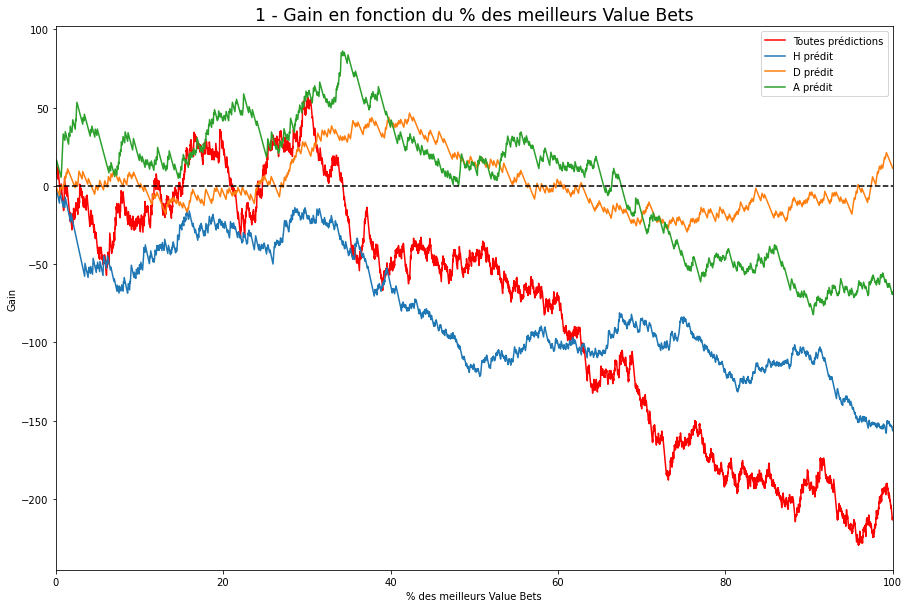

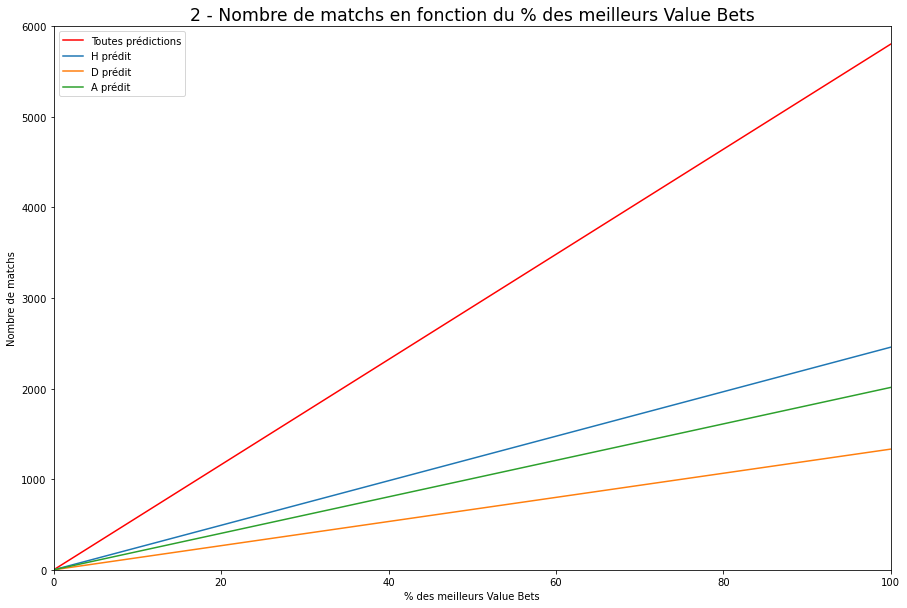

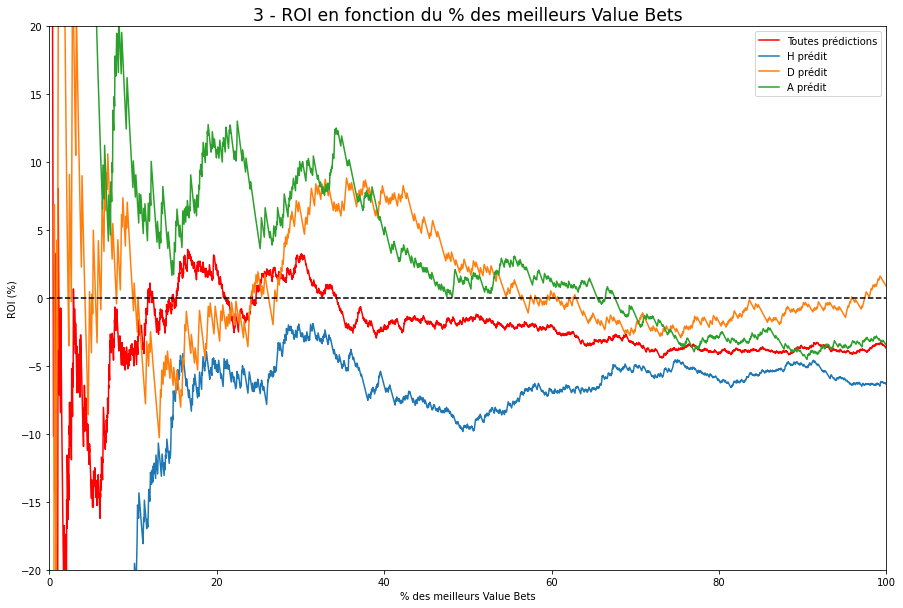

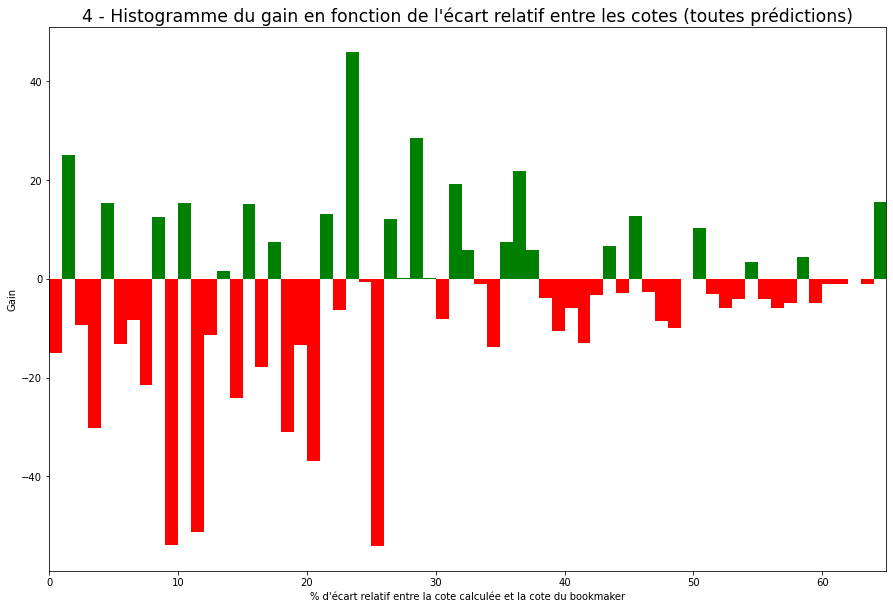

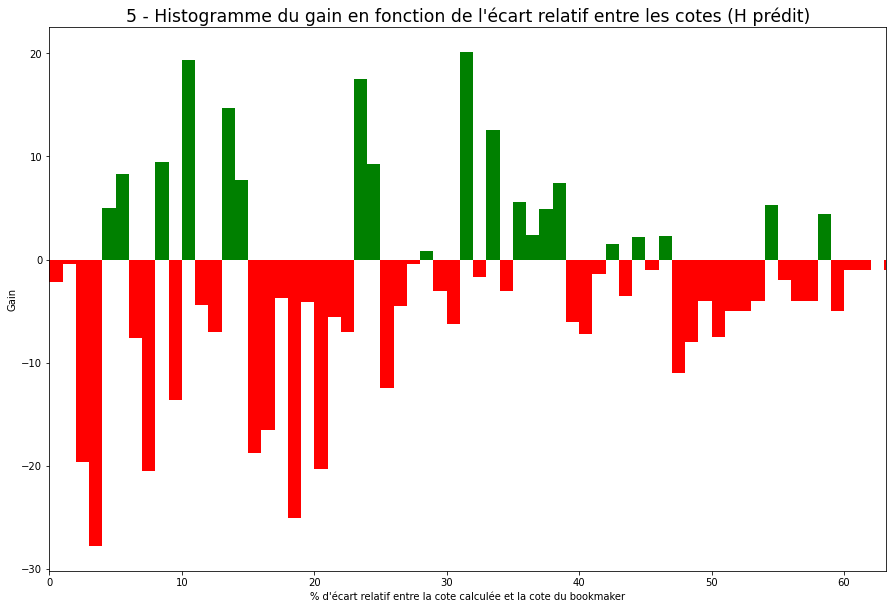

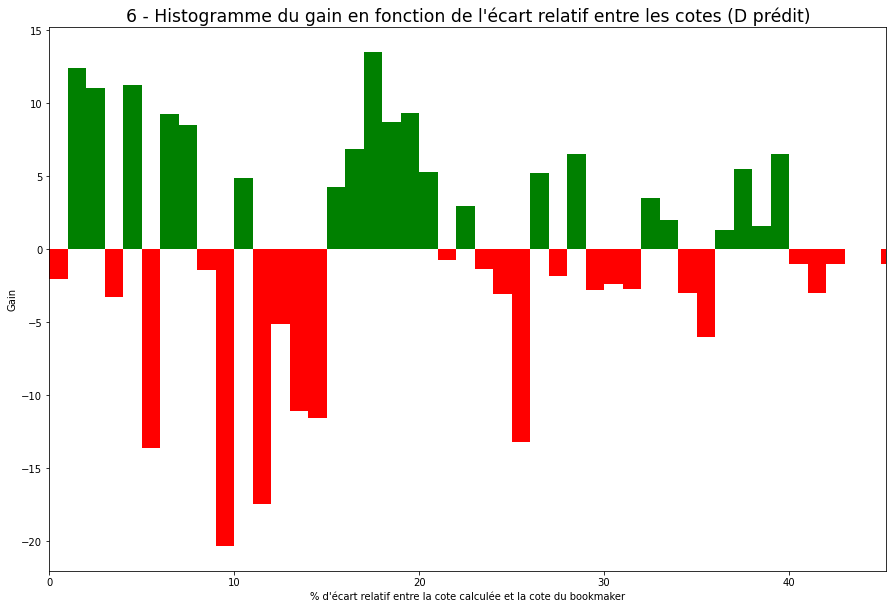

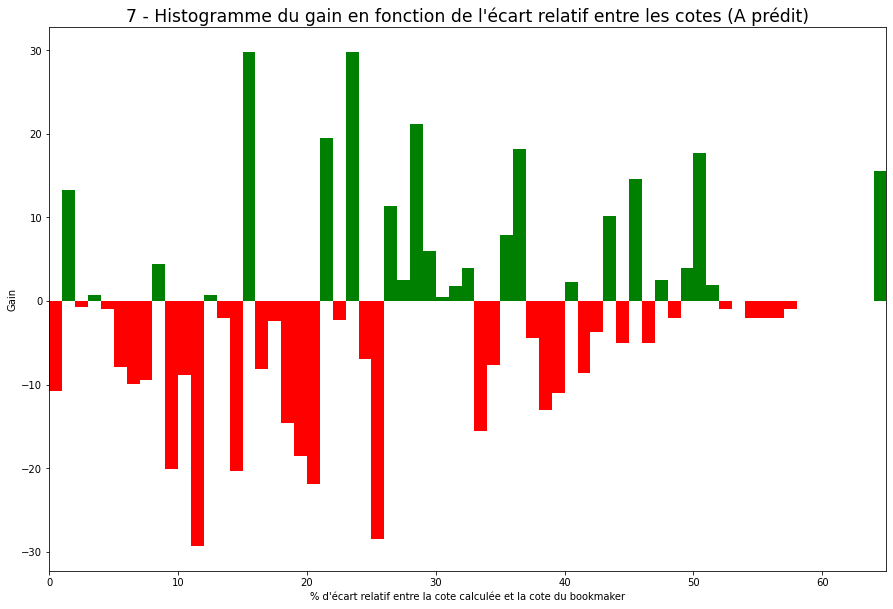

In [60]:
graphes(y_test , y_probs_test_knn)

Nous ne rentrerons pas ici dans le détail des résultats, ce sera fait dans le rapport pour le modèle ayant obtenu les meilleurs résultats.

# 4.4 XGBoost

Notre 4ème algorithme est le XGBoost.

De la même manière que pour le Random Forest, le XGBoost contient de nombreux paramètres. Il n'est pas possible dans un temps raisonnable d'effectuer une recherche sur tous les paramètres en même temps. Nous allons donc les regarder 1 par 1.

Optimisation du paramètre **n_estimators**.

**n_estimators :** nombre d'arbres dans notre ensemble ou nombre de tours pour le gradient boosting.

In [73]:
xgb = XGBClassifier(objective = 'multi:softprob')

In [74]:
cv = StratifiedKFold(n_splits = 3)

gains_score = make_scorer(score_func = gains , needs_proba = True)

params = {
        "n_estimators" : range(10 , 301 , 10),                                   
         }

grid_xgb = GridSearchCV(estimator = xgb , param_grid = params , cv = cv , scoring = {"gain" : gains_score , "accuracy" : accuracy} , n_jobs = -1 , verbose = 2 , return_train_score = True , refit = "gain")

In [75]:
%%time

grid_model_xgb = grid_xgb.fit(X_train_scaled , y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\matcr\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\matcr\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:39:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 23min 2s


Meilleurs paramètres.

In [79]:
grid_model_xgb.best_params_

{'n_estimators': 160}

Optimisation du paramètre **learning_rate**.

**learning_rate :** taille de pas à chaque itération, un **learning_rate** faible nécessite plus de tours pour obtenir la même réduction d'erreur résiduelle qu'un modèle avec taux d'apprentissage élevé, permet de réguler l'overfitting.

In [80]:
xgb = XGBClassifier(objective = 'multi:softprob' , n_estimators = 160)

In [81]:
cv = StratifiedKFold(n_splits = 3)

gains_score = make_scorer(score_func = gains , needs_proba = True)

params = {                
        "learning_rate" : np.arange(0.001 , 0.011 , 0.001)                  
         }

grid_xgb = GridSearchCV(estimator = xgb , param_grid = params , cv = cv , scoring = {"gain" : gains_score , "accuracy" : accuracy} , n_jobs = -1 , verbose = 2 , return_train_score = True , refit = "gain")

In [82]:
%%time

grid_model_xgb = grid_xgb.fit(X_train_scaled , y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\matcr\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\matcr\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[01:06:31] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 6min 23s


Meilleurs paramètres.

In [83]:
grid_model_xgb.best_params_

{'learning_rate': 0.008}

Optimisation du paramètre **max_depth**.

**max_depth :** profondeur maximale par arbre, un arbre plus profond peut augmenter les performances mais aussi la complexité du modèle.

In [87]:
xgb = XGBClassifier(objective = 'multi:softprob' , n_estimators = 160 , learning_rate = 0.008)

In [88]:
cv = StratifiedKFold(n_splits = 3)

gains_score = make_scorer(score_func = gains , needs_proba = True)

params = {
    "max_depth" : range(1 , 11 , 1)                 
         }

grid_xgb = GridSearchCV(estimator = xgb , param_grid = params , cv = cv , scoring = {"gain" : gains_score , "accuracy" : accuracy} , n_jobs = -1 , verbose = 2 , return_train_score = True , refit = "gain")

In [89]:
%%time

grid_model_xgb = grid_xgb.fit(X_train_scaled , y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\matcr\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\matcr\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:28:40] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 7min 55s


Meilleurs paramètres.

In [90]:
grid_model_xgb.best_params_

{'max_depth': 8}

Optimisation des paramètres **subsample** et **colsample_bytree**.

**subsample** : fraction d'observations (lignes) à échantillonner aléatoirement pour chaque arbre, les valeurs inférieures permettent de prévenir le surapprentissage.

**colsample_bytree :** fraction de variables explicatives (colonnes) à échantillonner aléatoirement pour chaque arbre, permet aussi d'éviter le surapprentissage.

In [91]:
xgb = XGBClassifier(learning_rate = 0.008 ,
                     n_estimators = 160 ,
                     max_depth = 8 ,
                     objective = 'multi:softprob')

In [92]:
cv = StratifiedKFold(n_splits = 3)

gains_score = make_scorer(score_func = gains , needs_proba = True)

params = {
    "subsample" : [i/100.0 for i in range(10 , 101 , 10)] ,
    "colsample_bytree" : [i/100.0 for i in range(10 , 101 , 10)]                  
         }

grid_xgb = GridSearchCV(estimator = xgb , param_grid = params , cv = cv , scoring = {"gain" : gains_score , "accuracy" : accuracy} , n_jobs = -1 , verbose = 2 , return_train_score = True , refit = "gain")

In [93]:
%%time

grid_model_xgb = grid_xgb.fit(X_train_scaled , y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\matcr\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\matcr\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:52:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 1h 22min 27s


Meilleurs paramètres.

In [94]:
grid_model_xgb.best_params_

{'colsample_bytree': 0.8, 'subsample': 1.0}

Optimisation des paramètres **reg_alpha** et **gamma**.

**reg_alpha :** Régularisation L1 sur les poids, permet d'améliorer les performances de vitesse lorsqu'il y a beaucoup de fonctionnalités.

**gamma** : paramètre de régularisation, permet de réduire la fonction de perte.

In [95]:
xgb = XGBClassifier(learning_rate = 0.008 ,
                     n_estimators = 160 ,
                     max_depth = 8 ,
                     subsample = 1.0 ,
                     colsample_bytree = 0.8 ,
                     objective = 'multi:softprob')

In [96]:
cv = StratifiedKFold(n_splits = 3)

gains_score = make_scorer(score_func = gains , needs_proba = True)

params = {
            "reg_alpha" : [i for i in range(5 , 31 , 5)] ,
            "gamma" : [i/10.0 for i in range(0 , 11)]
         }

grid_xgb = GridSearchCV(estimator = xgb , param_grid = params , cv = cv , scoring = {"gain" : gains_score , "accuracy" : accuracy} , n_jobs = -1 , verbose = 2 , return_train_score = True , refit = "gain")

In [97]:
%%time

grid_model_xgb = grid_xgb.fit(X_train_scaled , y_train)

Fitting 3 folds for each of 66 candidates, totalling 198 fits


C:\Users\matcr\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\matcr\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:29:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 58min 2s


Meilleurs paramètres.

In [98]:
grid_model_xgb.best_params_

{'gamma': 0.3, 'reg_alpha': 10}

Une fois les paramètres optimisés, nous pouvons sélectionner le meilleur modèle.

Sélection du meilleur modèle.

In [99]:
best_xgb = grid_model_xgb.best_estimator_
best_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0.3, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.008, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=160, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=10, reg_lambda=1, scale_pos_weight=None, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)

Entrainement du modèle.

In [100]:
best_xgb.fit(X_train_scaled , y_train)

[13:32:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0.3, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.008, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=160, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=10, reg_lambda=1, scale_pos_weight=None, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)

Calcul de l'accuracy sur le jeu de données d'entrainement (pour vérifier l'absence d'overfitting).

In [101]:
y_preds_train_xgb = best_xgb.predict(X_train_scaled)
y_probs_train_xgb = best_xgb.predict_proba(X_train_scaled)

print("Accuracy :" , round(100 * accuracy_score(y_train , y_preds_train_xgb) , 2) , "%")

Accuracy : 52.99 %


Calcul de l'accuracy sur le jeu de données de test (pour vérifier l'absence d'overfitting).

In [102]:
y_preds_test_xgb = best_xgb.predict(X_test_scaled)
y_probs_test_xgb = best_xgb.predict_proba(X_test_scaled)

print("Accuracy :" , round(100 * accuracy_score(y_test , y_preds_test_xgb) , 2) , "%")

Accuracy : 48.37 %


Les valeurs sont plutôt proches, nous n'avons pas beaucoup d'overfitting.

Détermination des variables explicatives les plus importantes.

[51/51] features ████████████████████ Time elapsed: 10 seconds

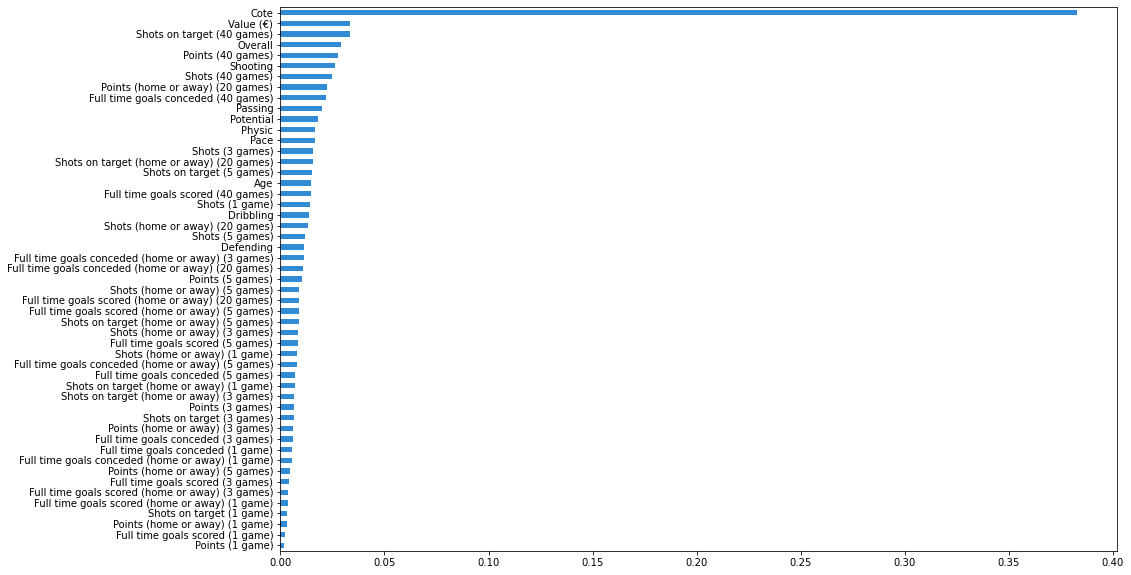

In [103]:
interpreter = Interpretation(X_train_scaled , feature_names = X_train_scaled.columns)

def predict_xgb(x):
    return pd.DataFrame(best_xgb.predict_proba(x))

model = InMemoryModel(predict_xgb , examples = X_train)
fig , ax = plt.subplots(figsize = (15 , 10))
interpreter.feature_importance.plot_feature_importance(model , ax = ax , ascending = False);

Nous pouvons observer que la variable **Cote** est de loin celle qui influence le plus notre modèle.

Regardons désormais le gain maximum obtenu.

In [104]:
infos_gains_max(y_test , y_probs_test_xgb)

Gain max : 19.0
Nombre de matchs : 18
ROI : 105.56 %


Le gain maximum correspond au maximum de la courbe rouge ci-dessous. Nous pouvons voir que le gain maximum est atteint très tôt, pour seulement les 18 meilleurs Value Bet. Nous avons donc un ROI très élevé, mais pour un nombre de matchs insuffisant, ce qui n'est pas exploitable pour espérer une stratégie de pari gagnante à long terme.

Tracé des graphes des résultats.

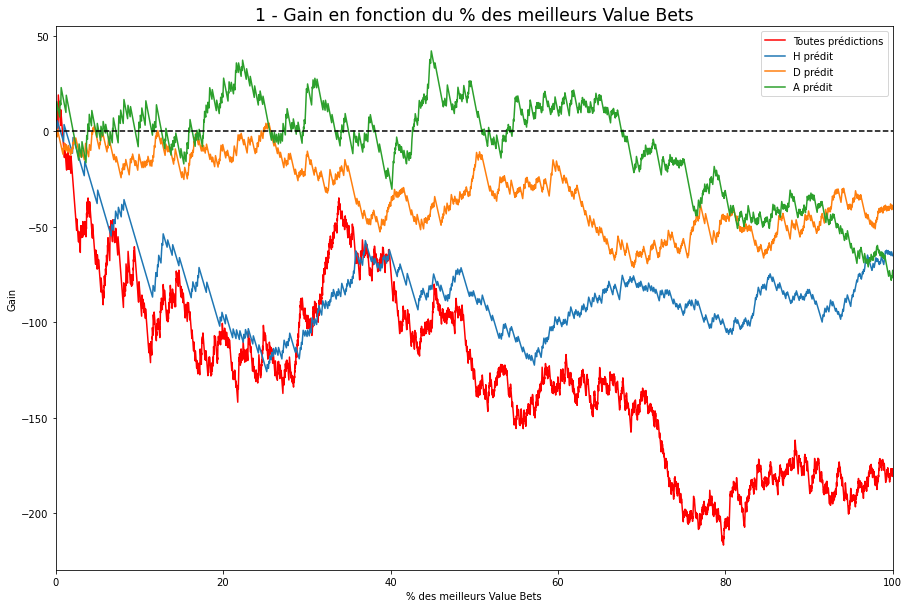

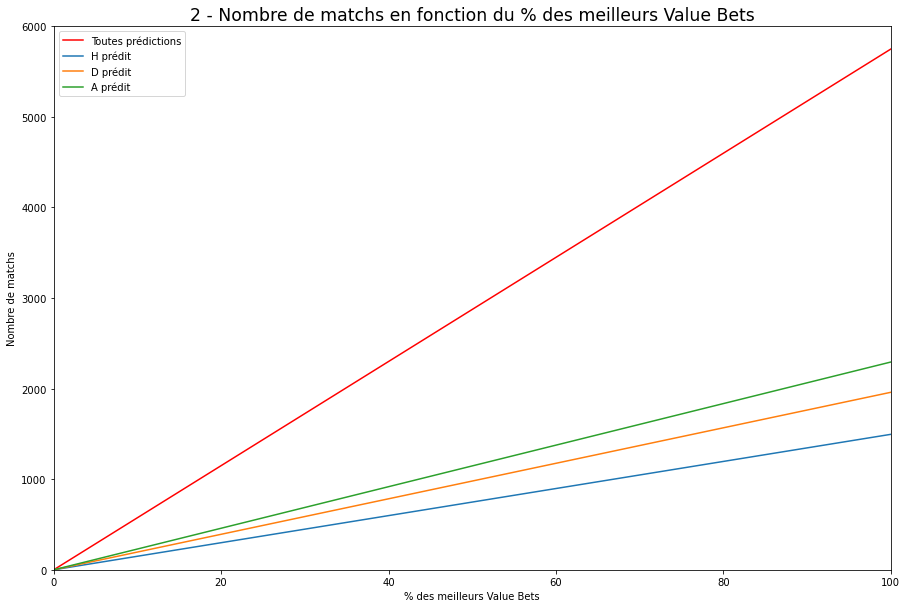

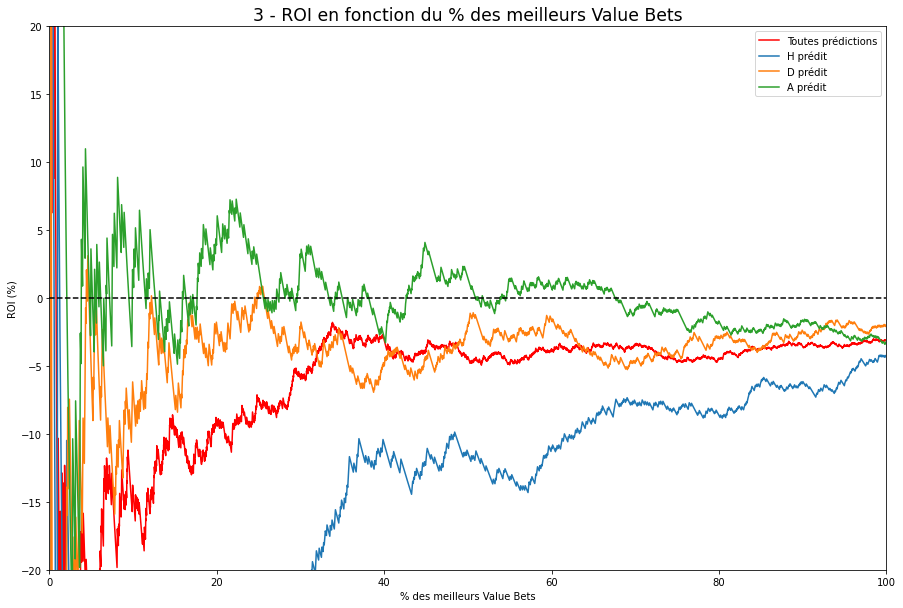

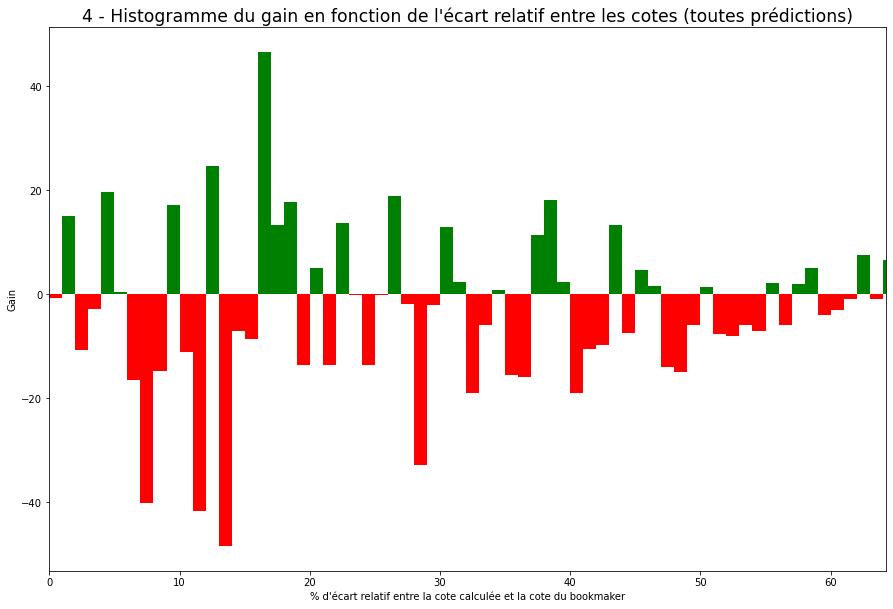

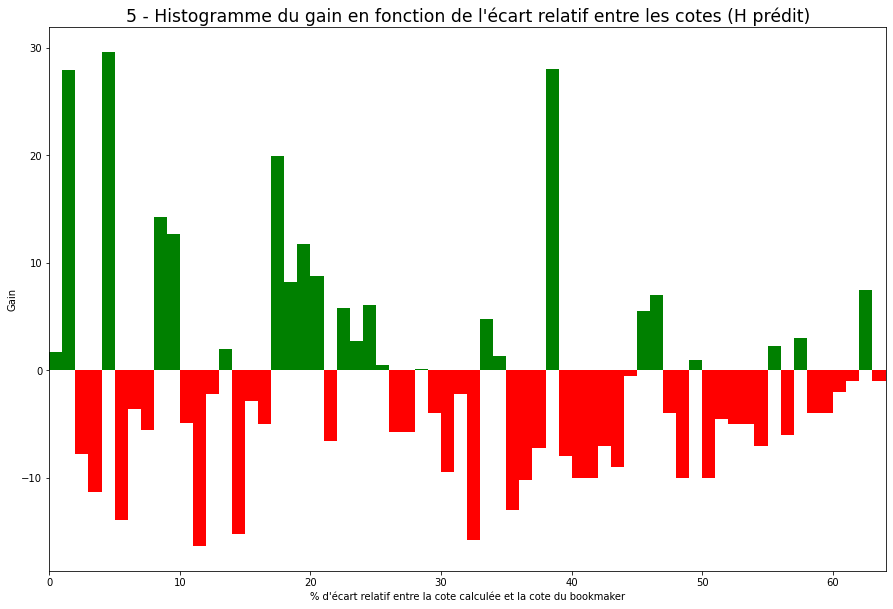

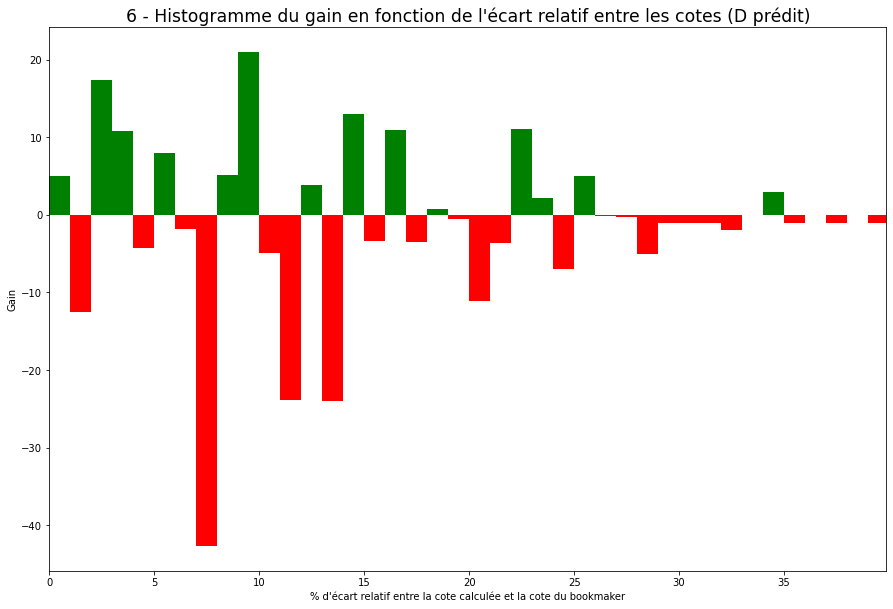

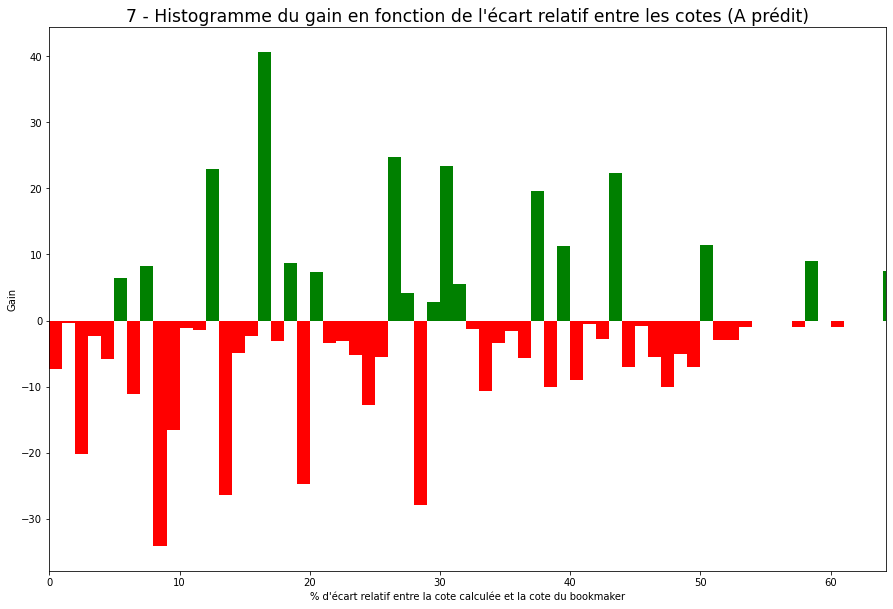

In [105]:
graphes(y_test , y_probs_test_xgb)

Nous ne rentrerons pas ici dans le détail des résultats, ce sera fait dans le rapport pour le modèle ayant obtenu les meilleurs résultats.

# 4.5 Random Forest (hyperopt)

Notre 5ème algorithme est encore un Random Forest.

Cette fois-ci, nous recherchons les meilleurs hyperparamètres à l'aide d'une autre technique, hyperopt.

Hyperopt est une alternative au gridsearch pour la recherche d'hyperparamètres optimisés reposant sur le principe d'optimisation Bayésienne: supposons que l'on cherche à determiner y en fonction de x, avec cette méthode on pourrait obtenir y maximal tout en minimisant x. Hyperopt nous permet donc d'obtenir des meilleurs résultats que le gridsearch avec un temps d'execution plus faible.

Ce concept repose sur 4 composants essentiels pour l'optimisation des hyperparamètres:

**L'espace de recherche :** permet de définir des plages pour les paramètres d'entrées, 

**La fonction objective :** la fonction qui doit être minimisée qui reçoit des valeurs d'hyperparamètres en entrée de l'espace de recherche et renvoie la perte,

**Fonction fmin :** fonction d'optimisation qui consiste à minimiser la fonction objective avec les algorithmes de recherche aléatoire(TPE),

**Objets d'essai :** base de données pour stocker l'historique (score, configuration).

Optimisation des paramètres.

In [113]:
space = {
    "n_estimators": hp.choice("n_estimators", np.arange(10, 101, 10, dtype=int)), 
    "max_depth": hp.choice("max_depth", np.arange(3, 16, 2, dtype=int)),
    "criterion": hp.choice("criterion", ["gini", "entropy"]),
    "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(20, 71, 10, dtype=int)),
    "min_samples_split": hp.choice("min_samples_split", np.arange(100,1001,100, dtype=int)),
    "max_features": hp.choice("max_features", ["sqrt", "log2"])
        }

In [107]:
cv = StratifiedKFold(n_splits = 3)

gains_score = make_scorer(score_func = gains , needs_proba = True)

def hyperparameter_tuning(params):
    clf = RandomForestClassifier(**params , n_jobs=-1)
    gain = cross_val_score(clf , X_train_scaled , y_train , scoring = gains_score , cv = cv).mean()
    return {"loss": -gain , "status": STATUS_OK}

In [108]:
%%time

trials = Trials()

best = fmin(
    fn = hyperparameter_tuning,
    space = space, 
    algo = tpe.suggest, 
    max_evals = 250, 
    trials = trials
            )

print("Best: {}".format(best))

100%|██████████| 250/250 [2:17:44<00:00, 33.06s/trial, best loss: -166.4866666666666]  
Best: {'criterion': 1, 'max_depth': 4, 'max_features': 1, 'min_samples_leaf': 4, 'min_samples_split': 1, 'n_estimators': 3}
Wall time: 2h 17min 44s


Nous obtenons la position des meilleurs paramètres dans les listes précisées dans **space** plus haut. Il suffit de retrouver la correspondance avec la valeur de chaque paramètre.

Sélection du meilleur modèle.

In [126]:
best_rfh = RandomForestClassifier(criterion = "entropy" , max_depth = 11 , max_features = "log2" , min_samples_leaf = 60 , min_samples_split = 200 , n_estimators = 40)
best_rfh

RandomForestClassifier(criterion='entropy', max_depth=11, max_features='log2',
                       min_samples_leaf=60, min_samples_split=200,
                       n_estimators=40)

Entrainement du modèle.

In [127]:
best_rfh.fit(X_train_scaled , y_train)

RandomForestClassifier(criterion='entropy', max_depth=11, max_features='log2',
                       min_samples_leaf=60, min_samples_split=200,
                       n_estimators=40)

Calcul de l'accuracy sur le jeu de données d'entrainement (pour vérifier l'absence d'overfitting).

In [128]:
y_preds_train_rfh = best_rfh.predict(X_train_scaled)
y_probs_train_rfh = best_rfh.predict_proba(X_train_scaled)

print("Accuracy :" , round(100 * accuracy_score(y_train , y_preds_train_rfh) , 2) , "%")

Accuracy : 49.51 %


Calcul de l'accuracy sur le jeu de données de test (pour vérifier l'absence d'overfitting).

In [129]:
y_preds_test_rfh = best_rfh.predict(X_test_scaled)
y_probs_test_rfh = best_rfh.predict_proba(X_test_scaled)

print("Accuracy :" , round(100 * accuracy_score(y_test , y_preds_test_rfh) , 2) , "%")

Accuracy : 47.25 %


Les valeurs sont plutôt proches, nous n'avons pas beaucoup d'overfitting.

Détermination des variables explicatives les plus importantes.

[51/51] features ████████████████████ Time elapsed: 10 seconds

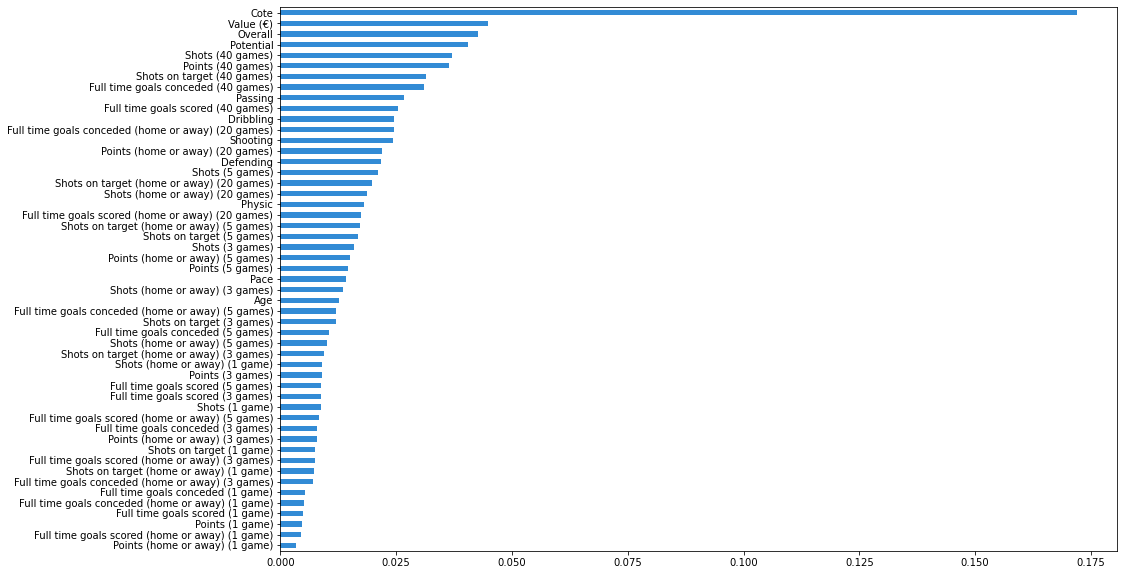

In [130]:
interpreter = Interpretation(X_train_scaled , feature_names = X_train_scaled.columns)

def predict_rfh(x):
    return pd.DataFrame(best_rfh.predict_proba(x))

model = InMemoryModel(predict_rfh , examples = X_train)
fig , ax = plt.subplots(figsize = (15 , 10))
interpreter.feature_importance.plot_feature_importance(model , ax = ax , ascending = False);

Nous pouvons observer que la variable **Cote** est de loin celle qui influence le plus notre modèle.

Regardons désormais le gain maximum obtenu.

In [131]:
infos_gains_max(y_test , y_probs_test_rfh)

Gain max : 23.25
Nombre de matchs : 20
ROI : 116.25 %


Le gain maximum correspond au maximum de la courbe rouge ci-dessous. Nous pouvons voir que le gain maximum est atteint très tôt, pour seulement les 20 meilleurs Value Bet. Nous avons donc un ROI très élevé, mais pour un nombre de matchs insuffisant, ce qui n'est pas exploitable pour espérer une stratégie de pari gagnante à long terme.

Tracé des graphes des résultats.

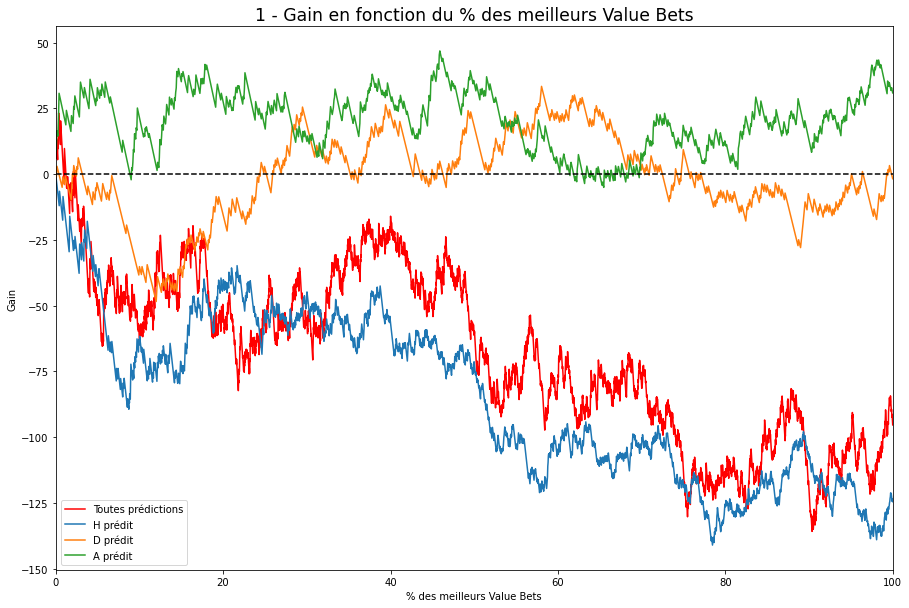

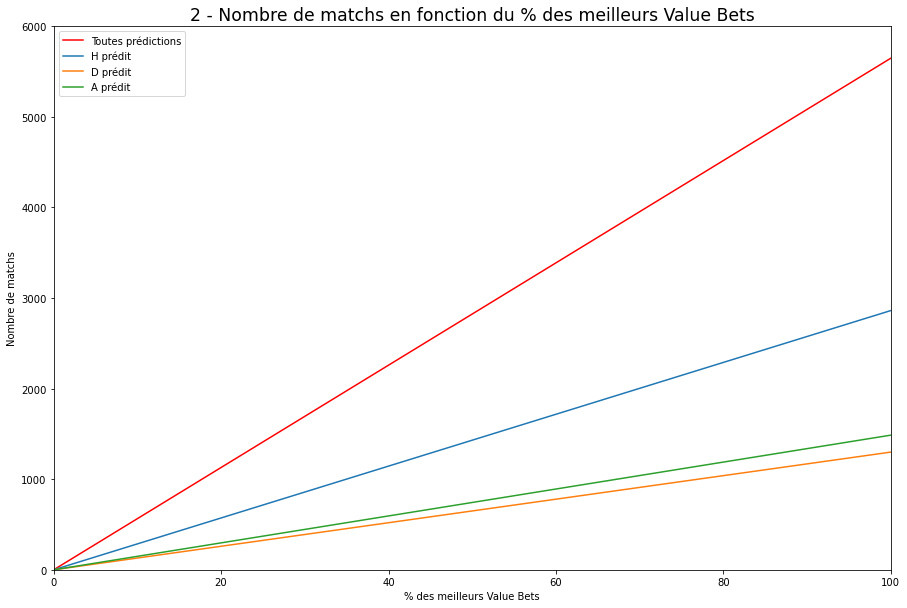

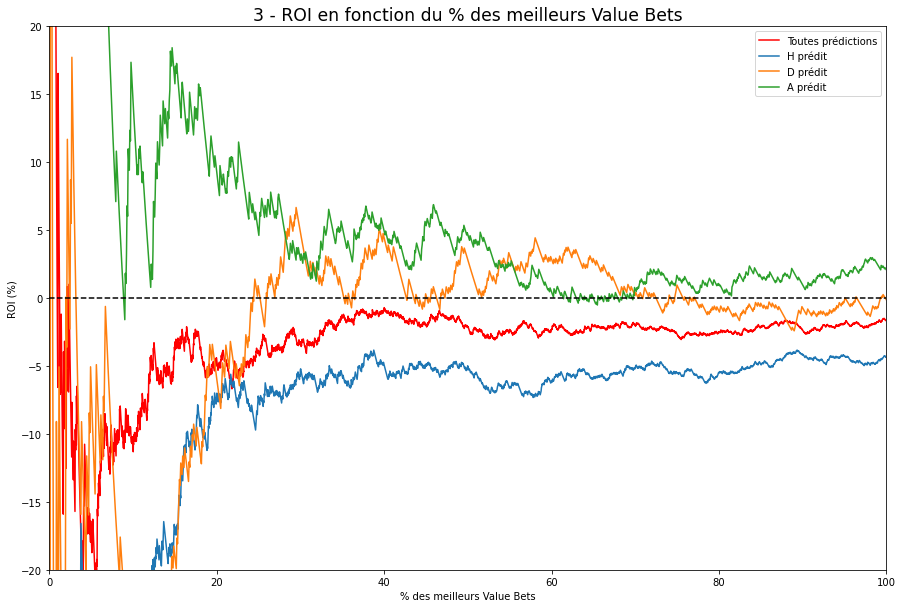

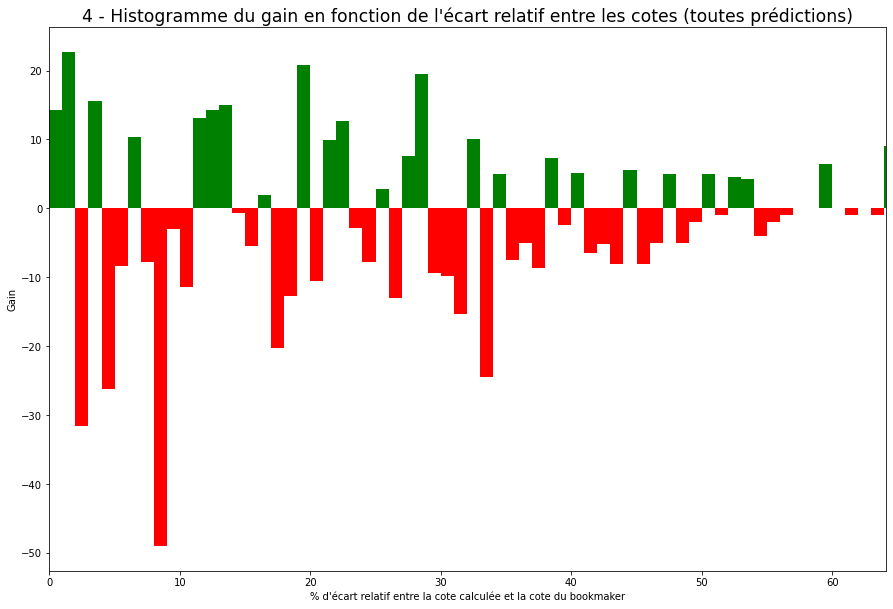

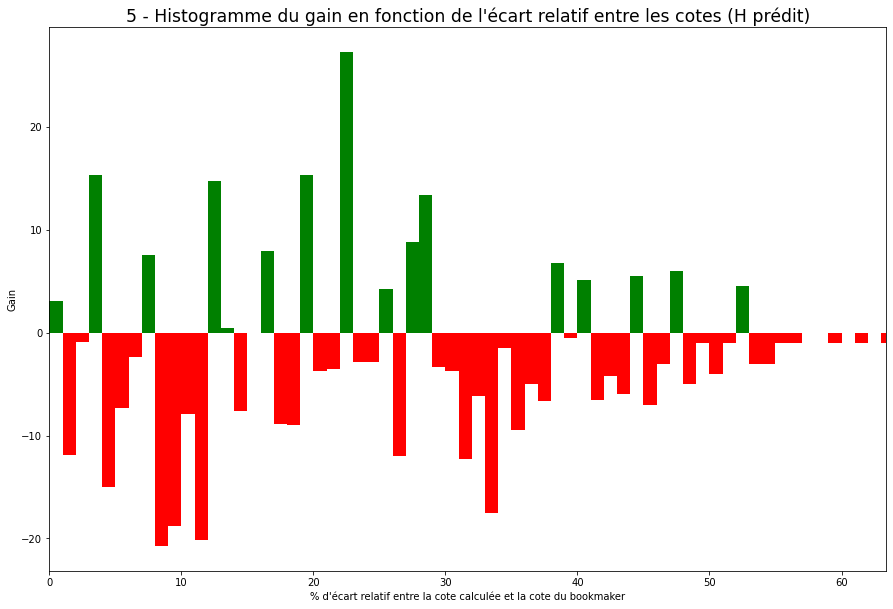

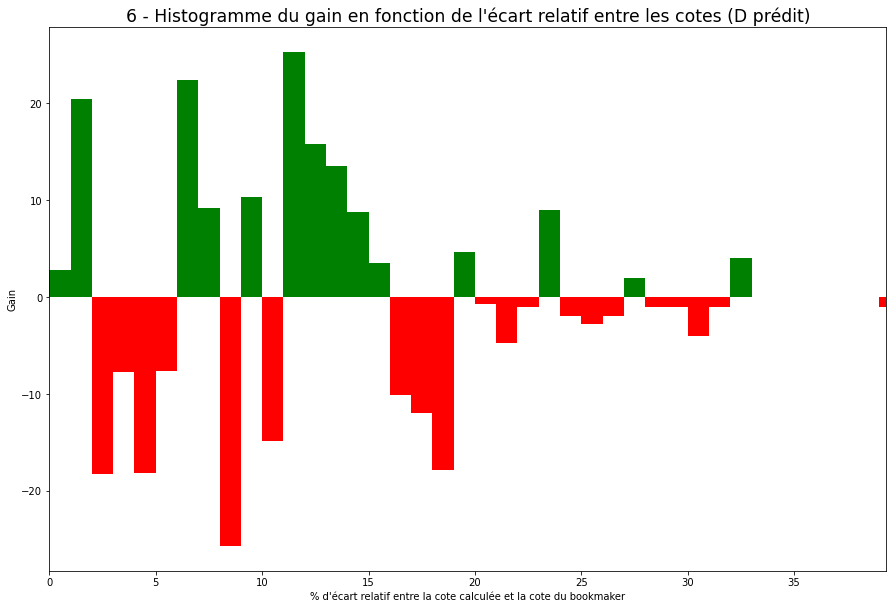

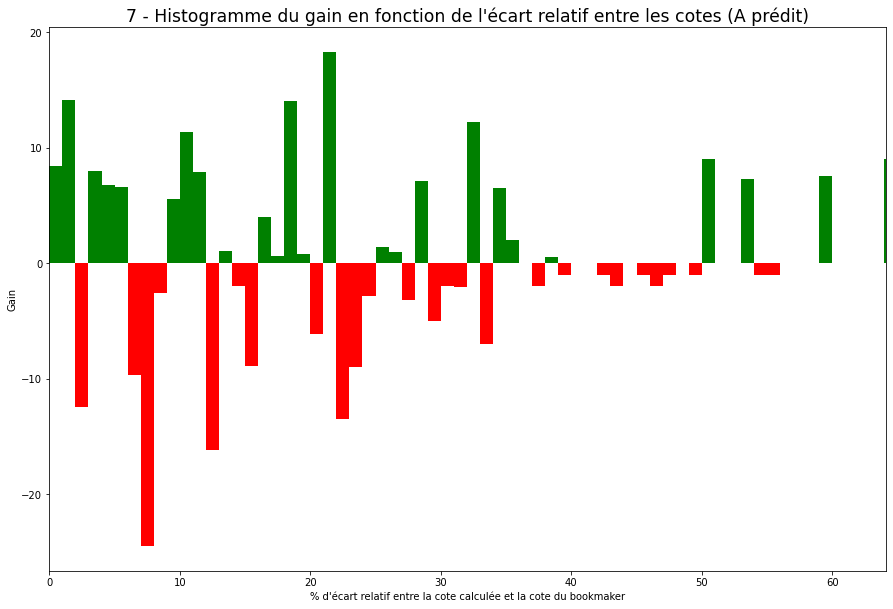

In [132]:
graphes(y_test , y_probs_test_rfh)

Nous ne rentrerons pas ici dans le détail des résultats, ce sera fait dans le rapport pour le modèle ayant obtenu les meilleurs résultats.

# 4.6 Voting Classifier

Pour finir, nous avons décidé de récupérer tous les modèles que nous avons développés précédemment pour les utiliser au travers d'un Voting Classifier.

Entrainement du modèle.

In [133]:
vc = VotingClassifier(estimators = [("xgb" , best_xgb) , ("knn" , best_knn) , ("svc" , best_svc) , ("rf" , best_rf) , ("rfh" , best_rfh)] , voting = "soft" , verbose = True , n_jobs = -1)
vc.fit(X_train_scaled , y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.8,
                                            enable_categorical=False, gamma=0.3,
                                            gpu_id=-1, importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.008,
                                            max_delta_step=0, max_depth=8,
                                            min_child_weight=1, missing=nan,
                                            monotone_constraints='()',
                                            n_estimat...
                             ('knn', KNeighborsClassifier(n_neighbors=134)),
                             ('svc',
 

Calcul de l'accuracy sur le jeu de données d'entrainement (pour vérifier l'absence d'overfitting).

In [134]:
y_preds_train_vc = vc.predict(X_train_scaled)
y_probs_train_vc = vc.predict_proba(X_train_scaled)

print("Accuracy :" , round(100 * accuracy_score(y_train , y_preds_train_vc) , 2) , "%")

Accuracy : 49.07 %


Calcul de l'accuracy sur le jeu de données de test (pour vérifier l'absence d'overfitting).

In [135]:
y_preds_test_vc = vc.predict(X_test_scaled)
y_probs_test_vc = vc.predict_proba(X_test_scaled)

print("Accuracy :" , round(100 * accuracy_score(y_test , y_preds_test_vc) , 2) , "%")

Accuracy : 47.24 %


Les valeurs sont proches, nous n'avons pas d'overfitting.

Détermination des variables explicatives les plus importantes.

[51/51] features ████████████████████ Time elapsed: 1452 seconds

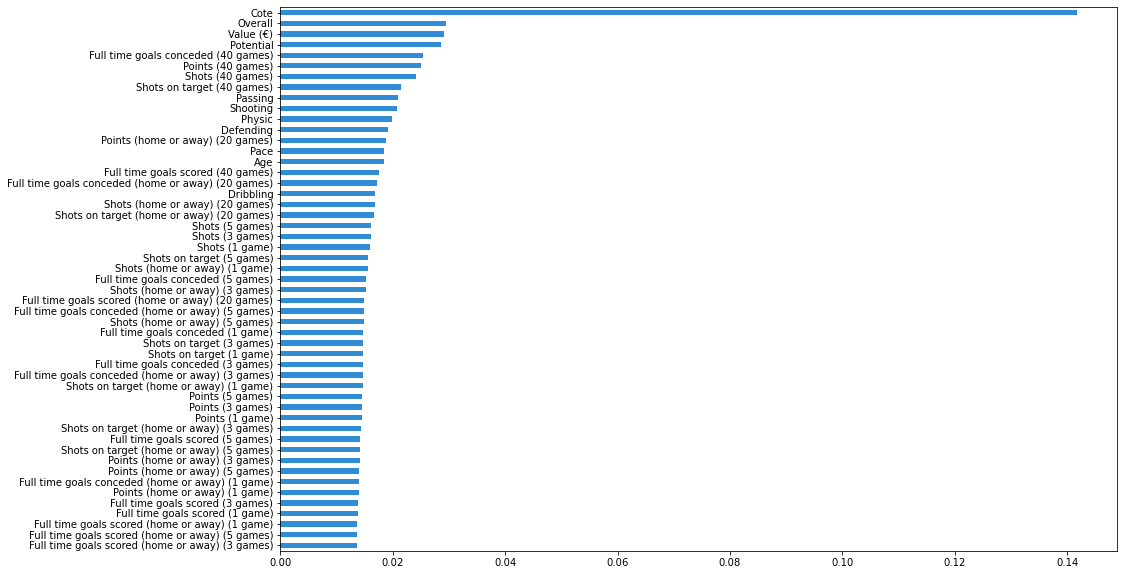

In [136]:
interpreter = Interpretation(X_train_scaled , feature_names = X_train_scaled.columns)

def predict_vc(x):
    return pd.DataFrame(vc.predict_proba(x))

model = InMemoryModel(predict_vc , examples = X_train)
fig , ax = plt.subplots(figsize = (15 , 10))
interpreter.feature_importance.plot_feature_importance(model , ax = ax , ascending = False);

Nous pouvons observer que la variable **Cote** est de loin celle qui influence le plus notre modèle.

Regardons désormais le gain maximum obtenu.

In [137]:
infos_gains_max(y_test , y_probs_test_vc)

Gain max : 15.7
Nombre de matchs : 39
ROI : 40.26 %


Le gain maximum correspond au maximum de la courbe rouge ci-dessous. Nous pouvons voir que le gain maximum est atteint très tôt, pour seulement les 39 meilleurs Value Bet. Nous avons donc un ROI très élevé, mais pour un nombre de matchs insuffisant, ce qui n'est pas exploitable pour espérer une stratégie de pari gagnante à long terme.

Tracé des graphes des résultats.

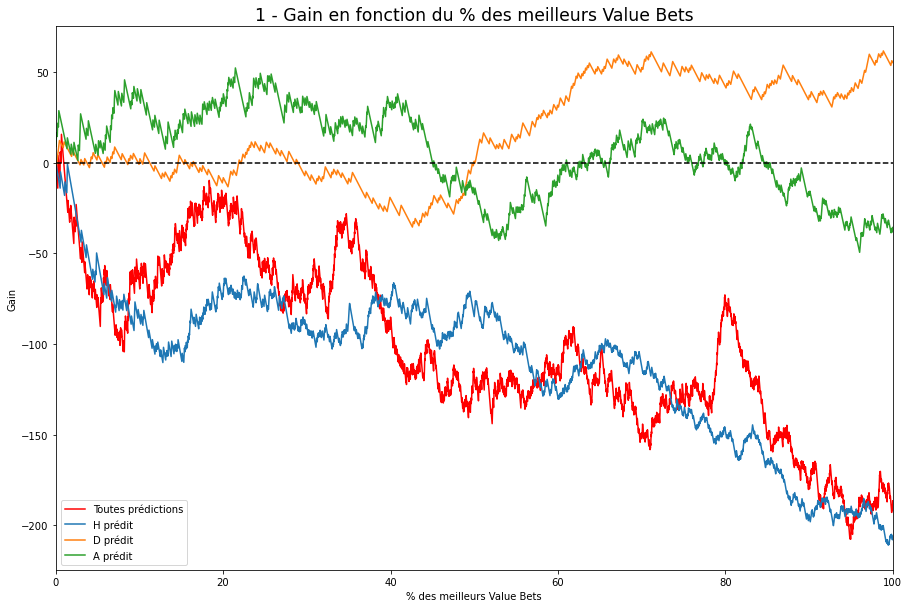

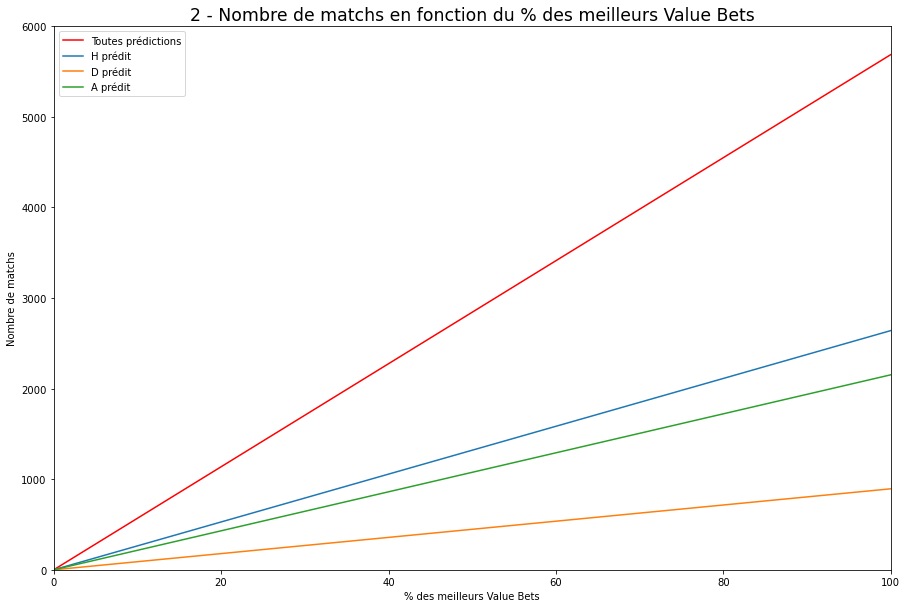

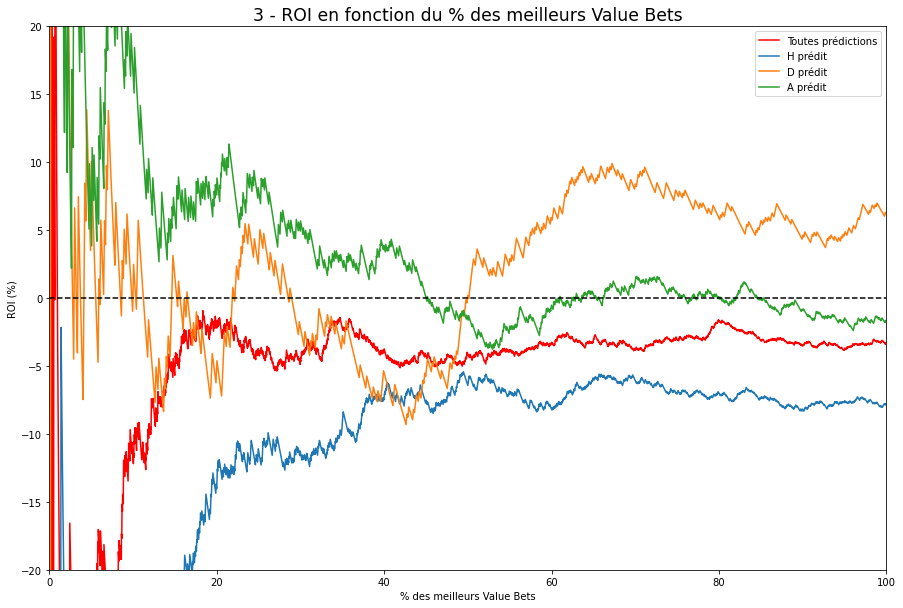

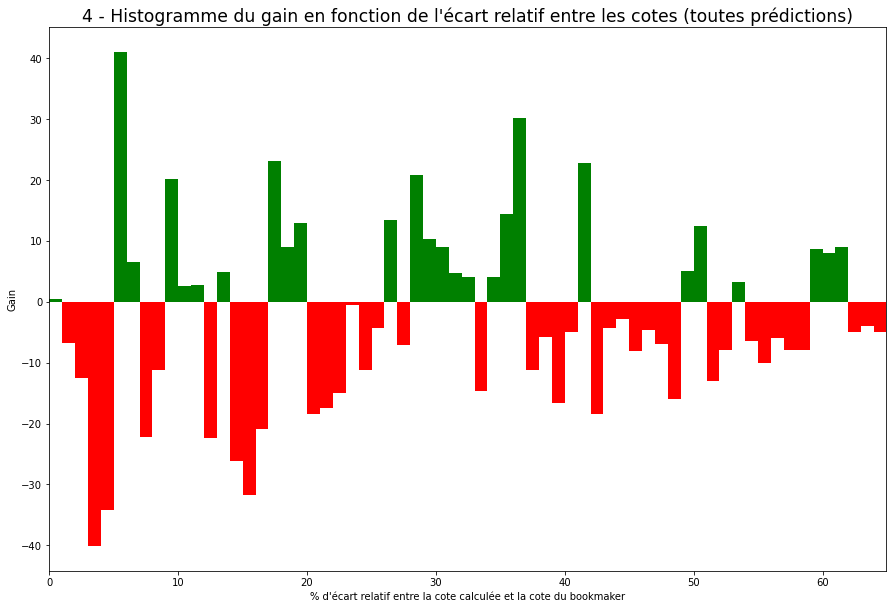

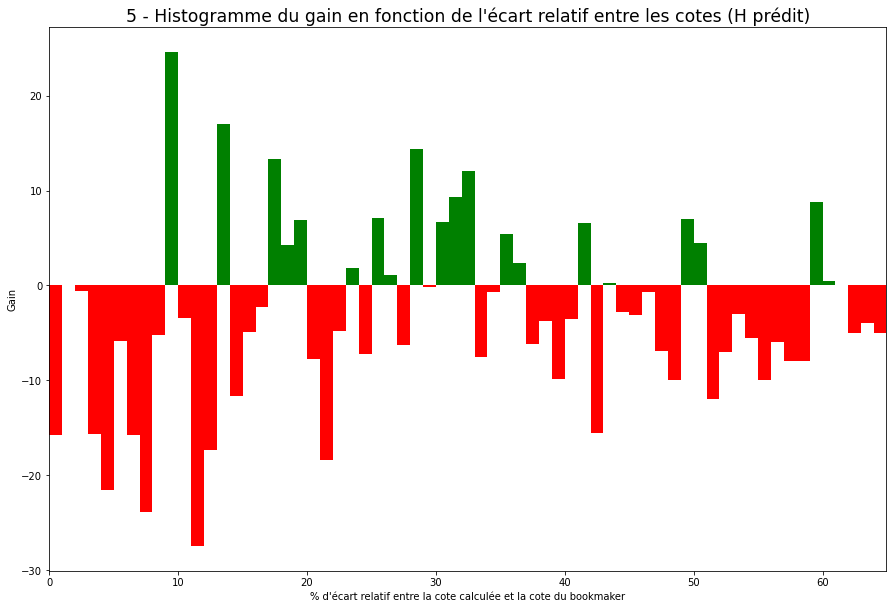

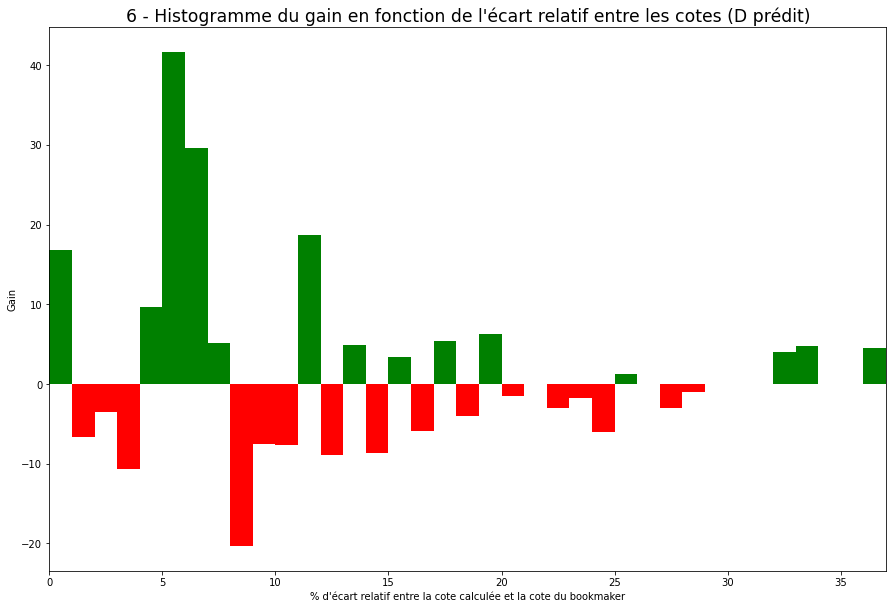

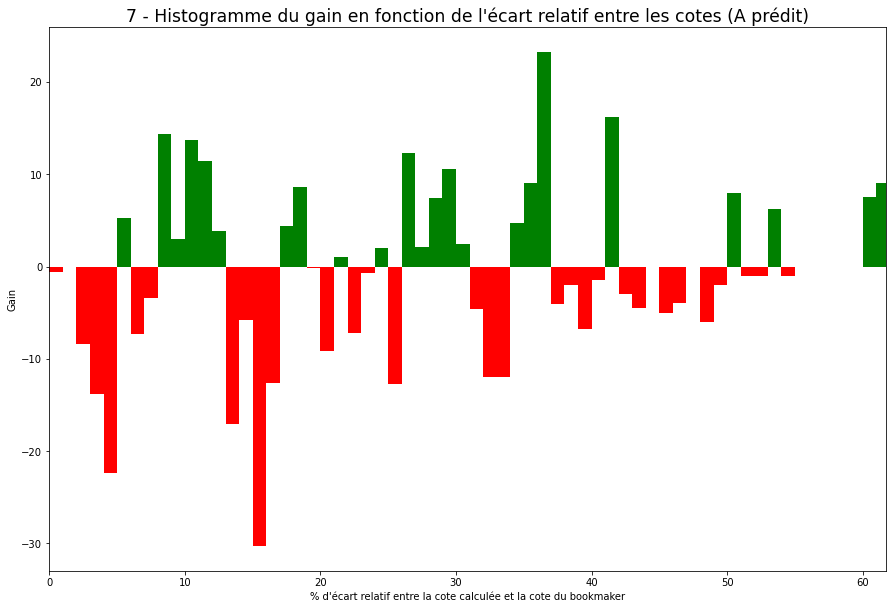

In [138]:
graphes(y_test , y_probs_test_vc)

Nous ne rentrerons pas ici dans le détail des résultats, ce sera fait dans le rapport pour le modèle ayant obtenu les meilleurs résultats.

# 5. Cas simples pour illustrer l'absence de corrélation entre accuracy et gain

Afin d'illustrer l'absence de corrélation directe entre accuracy et gain, nous avons préparé plusieurs cas simples pour l'illustrer.

Le récapitulatif de tous ces résultats est à retrouver dans le rapport.

# Prédiction H systématique

Dans cet exemple, nous parions systématiquement pour l'équipe à domicile.

Récupération des cotes des bookmakers pour les matchs du jeu de données de test.

In [139]:
df_gain = df.loc[y_test.index , ["Max H" , "Max D" , "Max A"]]

Renommage des colonnes.

In [140]:
df_gain = df_gain.rename(columns = {"Max H" : "Cote réelle H" , "Max D" : "Cote réelle D" , "Max A" : "Cote réelle A"})

Ajout du résultat réel.

In [141]:
df_gain["Résultat"] = df.loc[df_gain.index , "FTR"]

Détermination des paris.

In [142]:
df_gain["Pari"] = "H"

Calcul de l'accuracy.

In [143]:
print(pd.crosstab(df_gain["Résultat"] , df_gain["Pari"]))
print("\n" , "Accuracy :" , round(100 * accuracy_score(df_gain["Résultat"] , df_gain["Pari"]) , 2) , "%")

Pari         H
Résultat      
A         1970
D         1582
H         2346

 Accuracy : 39.78 %


Calcul des gains associés à nos paris.

In [144]:
for index in df_gain.index:
  if df_gain.loc[index , "Résultat"] == df_gain.loc[index , "Pari"]:
    df_gain.loc[index , "Résultat pari"] = 1
  else:
    df_gain.loc[index , "Résultat pari"] = 0

In [145]:
for index in df_gain.index:
  if df_gain.loc[index , "Résultat"] == "H":
    df_gain.loc[index , "Gain"] = df_gain.loc[index , "Cote réelle H"] * df_gain.loc[index , "Résultat pari"] - 1
  elif df_gain.loc[index , "Résultat"] == "D":
    df_gain.loc[index , "Gain"] = df_gain.loc[index , "Cote réelle D"] * df_gain.loc[index , "Résultat pari"] - 1
  elif df_gain.loc[index , "Résultat"] == "A":
    df_gain.loc[index , "Gain"] = df_gain.loc[index , "Cote réelle A"] * df_gain.loc[index , "Résultat pari"] - 1

In [146]:
gain_total = df_gain["Gain"].sum()
nb_matchs = df_gain.shape[0]
roi = 100 * gain_total / nb_matchs

print("Gains :\n")
print("Gain total :" , round(gain_total , 2) , "\n" , "Nombre de matchs :" , nb_matchs , "\n" , "ROI :" , round(roi , 2) , "%")

Gains :

Gain total : -290.82 
 Nombre de matchs : 5898 
 ROI : -4.93 %


# Prédiction D systématique

Dans cet exemple, nous parions systématiquement pour le match nul.

Récupération des cotes des bookmakers pour les matchs du jeu de données de test.

In [147]:
df_gain = df.loc[y_test.index , ["Max H" , "Max D" , "Max A"]]

Renommage des colonnes.

In [148]:
df_gain = df_gain.rename(columns = {"Max H" : "Cote réelle H" , "Max D" : "Cote réelle D" , "Max A" : "Cote réelle A"})

Ajout du résultat réel.

In [149]:
df_gain["Résultat"] = df.loc[df_gain.index , "FTR"]

Détermination des paris.

In [150]:
df_gain["Pari"] = "D"

Calcul de l'accuracy.

In [151]:
print(pd.crosstab(df_gain["Résultat"] , df_gain["Pari"]))
print("\n" , "Accuracy :" , round(100 * accuracy_score(df_gain["Résultat"] , df_gain["Pari"]) , 2) , "%")

Pari         D
Résultat      
A         1970
D         1582
H         2346

 Accuracy : 26.82 %


Calcul des gains associés à nos paris.

In [152]:
for index in df_gain.index:
  if df_gain.loc[index , "Résultat"] == df_gain.loc[index , "Pari"]:
    df_gain.loc[index , "Résultat pari"] = 1
  else:
    df_gain.loc[index , "Résultat pari"] = 0

In [153]:
for index in df_gain.index:
  if df_gain.loc[index , "Résultat"] == "H":
    df_gain.loc[index , "Gain"] = df_gain.loc[index , "Cote réelle H"] * df_gain.loc[index , "Résultat pari"] - 1
  elif df_gain.loc[index , "Résultat"] == "D":
    df_gain.loc[index , "Gain"] = df_gain.loc[index , "Cote réelle D"] * df_gain.loc[index , "Résultat pari"] - 1
  elif df_gain.loc[index , "Résultat"] == "A":
    df_gain.loc[index , "Gain"] = df_gain.loc[index , "Cote réelle A"] * df_gain.loc[index , "Résultat pari"] - 1

In [154]:
gain_total = df_gain["Gain"].sum()
nb_matchs = df_gain.shape[0]
roi = 100 * gain_total / nb_matchs

print("Gains :\n")
print("Gain total :" , round(gain_total , 2) , "\n" , "Nombre de matchs :" , nb_matchs , "\n" , "ROI :" , round(roi , 2) , "%")

Gains :

Gain total : -213.13 
 Nombre de matchs : 5898 
 ROI : -3.61 %


# Prédiction A systématique

Dans cet exemple, nous parions systématiquement pour l'équipe à l'extérieur.

Récupération des cotes des bookmakers pour les matchs du jeu de données de test.

In [155]:
df_gain = df.loc[y_test.index , ["Max H" , "Max D" , "Max A"]]

Renommage des colonnes.

In [156]:
df_gain = df_gain.rename(columns = {"Max H" : "Cote réelle H" , "Max D" : "Cote réelle D" , "Max A" : "Cote réelle A"})

Ajout du résultat réel.

In [157]:
df_gain["Résultat"] = df.loc[df_gain.index , "FTR"]

Détermination des paris.

In [158]:
df_gain["Pari"] = "A"

Calcul de l'accuracy.

In [159]:
print(pd.crosstab(df_gain["Résultat"] , df_gain["Pari"]))
print("\n" , "Accuracy :" , round(100 * accuracy_score(df_gain["Résultat"] , df_gain["Pari"]) , 2) , "%")

Pari         A
Résultat      
A         1970
D         1582
H         2346

 Accuracy : 33.4 %


Calcul des gains associés à nos paris.

In [160]:
for index in df_gain.index:
  if df_gain.loc[index , "Résultat"] == df_gain.loc[index , "Pari"]:
    df_gain.loc[index , "Résultat pari"] = 1
  else:
    df_gain.loc[index , "Résultat pari"] = 0

In [161]:
for index in df_gain.index:
  if df_gain.loc[index , "Résultat"] == "H":
    df_gain.loc[index , "Gain"] = df_gain.loc[index , "Cote réelle H"] * df_gain.loc[index , "Résultat pari"] - 1
  elif df_gain.loc[index , "Résultat"] == "D":
    df_gain.loc[index , "Gain"] = df_gain.loc[index , "Cote réelle D"] * df_gain.loc[index , "Résultat pari"] - 1
  elif df_gain.loc[index , "Résultat"] == "A":
    df_gain.loc[index , "Gain"] = df_gain.loc[index , "Cote réelle A"] * df_gain.loc[index , "Résultat pari"] - 1

In [162]:
gain_total = df_gain["Gain"].sum()
nb_matchs = df_gain.shape[0]
roi = 100 * gain_total / nb_matchs

print("Gains :\n")
print("Gain total :" , round(gain_total , 2) , "\n" , "Nombre de matchs :" , nb_matchs , "\n" , "ROI :" , round(roi , 2) , "%")

Gains :

Gain total : -3.62 
 Nombre de matchs : 5898 
 ROI : -0.06 %


# Prédiction favori

Dans cet exemple, nous parions systématiquement pour le favori.

Récupération des cotes des bookmakers pour les matchs du jeu de données de test.

In [163]:
df_gain = df.loc[y_test.index , ["Max H" , "Max D" , "Max A"]]

Renommage des colonnes.

In [164]:
df_gain = df_gain.rename(columns = {"Max H" : "Cote réelle H" , "Max D" : "Cote réelle D" , "Max A" : "Cote réelle A"})

Ajout du résultat réel.

In [165]:
df_gain["Résultat"] = df.loc[df_gain.index , "FTR"]

Détermination des paris.

In [166]:
for index in df_gain.index:
  if df_gain.loc[index , ["Cote réelle H" , "Cote réelle D" , "Cote réelle A"]].min() == df_gain.loc[index , "Cote réelle H"]:
    df_gain.loc[index , "Pari"] = "H"
  elif df_gain.loc[index , ["Cote réelle H" , "Cote réelle D" , "Cote réelle A"]].min() == df_gain.loc[index , "Cote réelle D"]:
    df_gain.loc[index , "Pari"] = "D"
  elif df_gain.loc[index , ["Cote réelle H" , "Cote réelle D" , "Cote réelle A"]].min() == df_gain.loc[index , "Cote réelle A"]:
    df_gain.loc[index , "Pari"] = "A"
  else:
    raise ValueError

Calcul de l'accuracy.

In [167]:
print(pd.crosstab(df_gain["Résultat"] , df_gain["Pari"]))
print("\n" , "Accuracy :" , round(100 * accuracy_score(df_gain["Résultat"] , df_gain["Pari"]) , 2) , "%")

Pari         A   D     H
Résultat                
A         1035  11   924
D          573  10   999
H          528   5  1813

 Accuracy : 48.46 %


Calcul des gains associés à nos paris.

In [168]:
for index in df_gain.index:
  if df_gain.loc[index , "Résultat"] == df_gain.loc[index , "Pari"]:
    df_gain.loc[index , "Résultat pari"] = 1
  else:
    df_gain.loc[index , "Résultat pari"] = 0

In [169]:
for index in df_gain.index:
  if df_gain.loc[index , "Résultat"] == "H":
    df_gain.loc[index , "Gain"] = df_gain.loc[index , "Cote réelle H"] * df_gain.loc[index , "Résultat pari"] - 1
  elif df_gain.loc[index , "Résultat"] == "D":
    df_gain.loc[index , "Gain"] = df_gain.loc[index , "Cote réelle D"] * df_gain.loc[index , "Résultat pari"] - 1
  elif df_gain.loc[index , "Résultat"] == "A":
    df_gain.loc[index , "Gain"] = df_gain.loc[index , "Cote réelle A"] * df_gain.loc[index , "Résultat pari"] - 1

In [170]:
gain_total = df_gain["Gain"].sum()
nb_matchs = df_gain.shape[0]
roi = 100 * gain_total / nb_matchs

print("Gains :\n")
print("Gain total :" , round(gain_total , 2) , "\n" , "Nombre de matchs :" , nb_matchs , "\n" , "ROI :" , round(roi , 2) , "%")

Gains :

Gain total : -44.45 
 Nombre de matchs : 5898 
 ROI : -0.75 %


# Prédiction grosse cote

Dans cet exemple, nous parions systématiquement pour la grosse cote.

Récupération des cotes des bookmakers pour les matchs du jeu de données de test.

In [171]:
df_gain = df.loc[y_test.index , ["Max H" , "Max D" , "Max A"]]

Renommage des colonnes.

In [172]:
df_gain = df_gain.rename(columns = {"Max H" : "Cote réelle H" , "Max D" : "Cote réelle D" , "Max A" : "Cote réelle A"})

Ajout du résultat réel.

In [173]:
df_gain["Résultat"] = df.loc[df_gain.index , "FTR"]

Détermination des paris.

In [174]:
for index in df_gain.index:
  if df_gain.loc[index , ["Cote réelle H" ,	"Cote réelle D" ,	"Cote réelle A"]].max() == df_gain.loc[index , "Cote réelle H"]:
    df_gain.loc[index , "Pari"] = "H"
  elif df_gain.loc[index , ["Cote réelle H" ,	"Cote réelle D" ,	"Cote réelle A"]].max() == df_gain.loc[index , "Cote réelle D"]:
    df_gain.loc[index , "Pari"] = "D"
  elif df_gain.loc[index , ["Cote réelle H" ,	"Cote réelle D" ,	"Cote réelle A"]].max() == df_gain.loc[index , "Cote réelle A"]:
    df_gain.loc[index , "Pari"] = "A"
  else:
    raise ValueError

Calcul de l'accuracy.

In [175]:
print(pd.crosstab(df_gain["Résultat"] , df_gain["Pari"]))
print("\n" , "Accuracy :" , round(100 * accuracy_score(df_gain["Résultat"] , df_gain["Pari"]) , 2) , "%")

Pari         A    D    H
Résultat                
A          548  790  632
D          679  599  304
H         1354  734  258

 Accuracy : 23.82 %


Calcul des gains associés à nos paris.

In [176]:
for index in df_gain.index:
  if df_gain.loc[index , "Résultat"] == df_gain.loc[index , "Pari"]:
    df_gain.loc[index , "Résultat pari"] = 1
  else:
    df_gain.loc[index , "Résultat pari"] = 0

In [177]:
for index in df_gain.index:
  if df_gain.loc[index , "Résultat"] == "H":
    df_gain.loc[index , "Gain"] = df_gain.loc[index , "Cote réelle H"] * df_gain.loc[index , "Résultat pari"] - 1
  elif df_gain.loc[index , "Résultat"] == "D":
    df_gain.loc[index , "Gain"] = df_gain.loc[index , "Cote réelle D"] * df_gain.loc[index , "Résultat pari"] - 1
  elif df_gain.loc[index , "Résultat"] == "A":
    df_gain.loc[index , "Gain"] = df_gain.loc[index , "Cote réelle A"] * df_gain.loc[index , "Résultat pari"] - 1

In [178]:
gain_total = df_gain["Gain"].sum()
nb_matchs = df_gain.shape[0]
roi = 100 * gain_total / nb_matchs

print("Gains :\n")
print("Gain total :" , round(gain_total , 2) , "\n" , "Nombre de matchs :" , nb_matchs , "\n" , "ROI :" , round(roi , 2) , "%")

Gains :

Gain total : -196.77 
 Nombre de matchs : 5898 
 ROI : -3.34 %
